## Table Of Contents <a name = "index"></a>
- [1. Data Analysis](#1)
  - [1.1. Overview](#11)
  - [1.2. Correlations](#12)
- [2. Data Preparation](#2)
  - [2.1. Feature Selection](#21)
    - [2.1.A. Univariate Selection](#21A)
    - [2.1.B. Recursive Feature Elimination](#21B)
    - [2.1.C. Feature Importance](#21C)
  - [2.2. Data Cleaning](#22)
  - [2.3. Data Formatting](#23)
- [3. Data Modeling](#3)
  - [3.1. Hyperparameter Tuning](#31)
  - [3.2. Apply Stratified K-Folds Cross Validation](#32)
- [4. Evaluation](#4)
  - [4.1. Results](#41)
  - [4.2. Confusion Matrix](#42)
  - [4.3. ROC Curve](#43)
  - [4.4. Best Scenery (Number 2)](#44)
    - [4.4.1. Best Model (MLP Classifier)](#441)
    - [4.4.2. All Models](#442)

In [ ]:
#delete all the outputs
#cmd: jupyter nbconvert --clear-output --inplace esrbRatingNoteBook.ipynb

import pandas as pd
import numpy as np

import sweetviz as sv
from pandas_profiling import ProfileReport

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

# Data formatting (Imbalanced Dataset)
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import LogisticRegression #already imported in feature selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from time import perf_counter

# StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# ROC
import matplotlib.patches as patches
from sklearn.metrics import roc_curve,auc

import warnings
warnings.filterwarnings("ignore")

# 1. Data Analysis <a name = "1"></a>
[Voltar ao Índice](#index)

In [2]:
df = pd.read_csv('data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1421 non-null   int64 
 1   title                     1421 non-null   object
 2   console                   1421 non-null   int64 
 3   alcohol_reference         1421 non-null   int64 
 4   animated_blood            1421 non-null   int64 
 5   blood                     1421 non-null   int64 
 6   blood_and_gore            1421 non-null   int64 
 7   cartoon_violence          1421 non-null   int64 
 8   crude_humor               1421 non-null   int64 
 9   drug_reference            1421 non-null   int64 
 10  fantasy_violence          1421 non-null   int64 
 11  intense_violence          1421 non-null   int64 
 12  language                  1421 non-null   int64 
 13  lyrics                    1421 non-null   int64 
 14  mature_humor            

## 1.1. Overview <a name = "11"></a>
[Voltar ao Índice](#index)

In [3]:
# SweetViz
my_report = sv.analyze(df)
my_report.show_html(filepath='analysis-reports/sv_train_report.html', open_browser=False)

                                             |                                             | [  0%]   00:00 ->…

Report analysis-reports/sv_train_report.html was generated.


In [4]:
# Pandas Profiling
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("analysis-reports/pandas_train_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 1.2. Correlations <a name = "12"></a>
[Voltar ao Índice](#index)

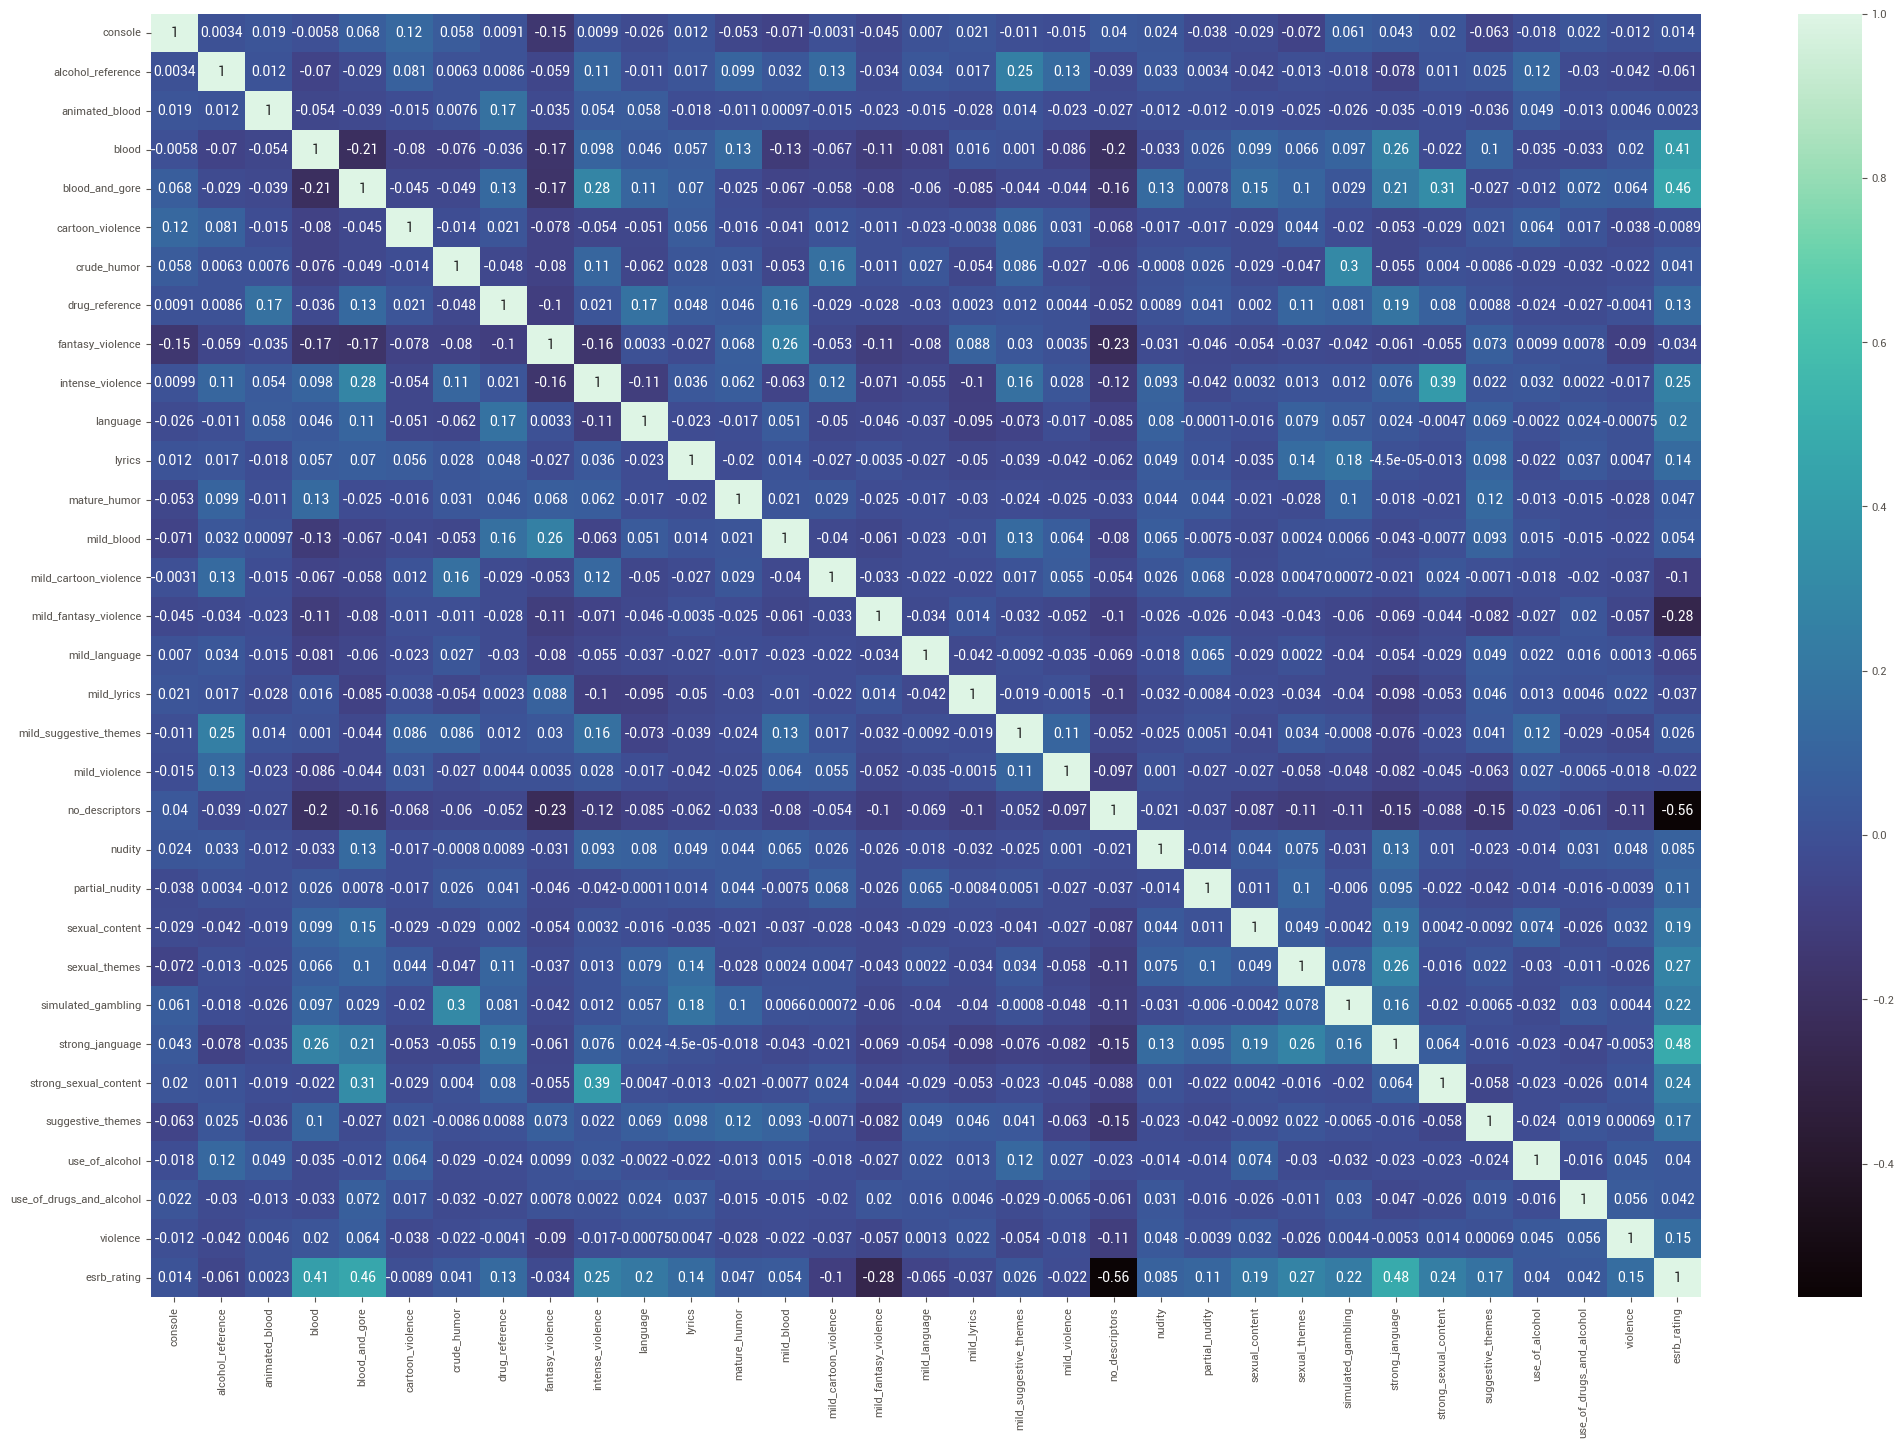

In [5]:
dataAnalysis = pd.read_csv('data/train.csv')

dataAnalysis.drop(['id', 'title'], axis = 1, inplace = True)

mapp = {
  'E' : 0,
  'ET': 1,
  'T' : 2,
  'M' : 3
}
dataAnalysis['esrb_rating'] = dataAnalysis['esrb_rating'].map(mapp)

plt.figure(figsize = (25, 17))
featuresRequired = dataAnalysis.columns
sns.heatmap(dataAnalysis[featuresRequired].corr(), annot = True, fmt='.2g', cmap='mako')
plt.savefig("analysis-reports/corr_graph.png")
plt.show()

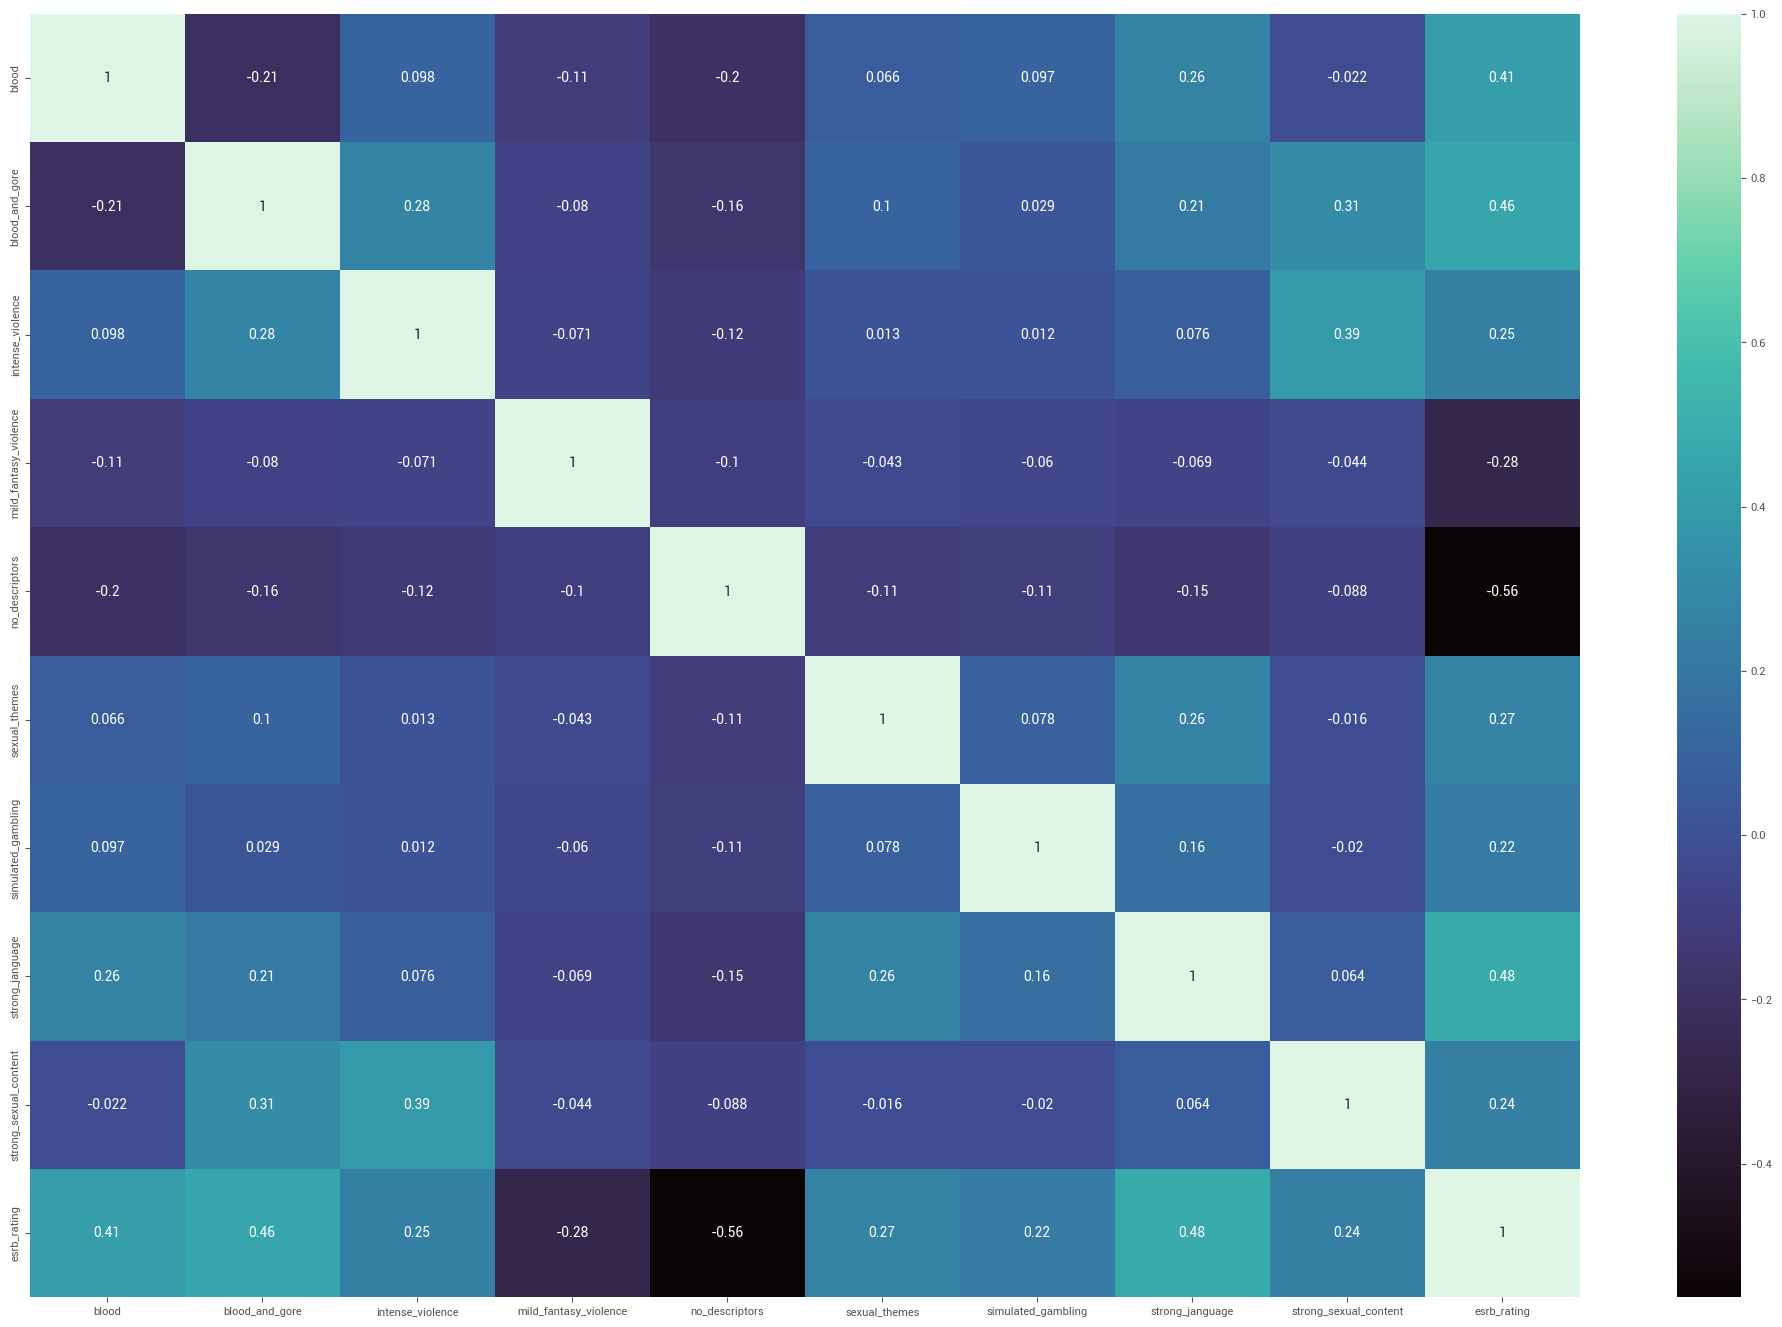

In [6]:
dataAnalysis = pd.read_csv('data/train.csv')

dataAnalysis = dataAnalysis[['blood', 'blood_and_gore', 'intense_violence', 'mild_fantasy_violence', 'no_descriptors', 'sexual_themes', 'simulated_gambling', 'strong_janguage', 'strong_sexual_content', 'esrb_rating']]

mapp = { 'E' : 0,
  'ET': 1,
  'T' : 2,
  'M' : 3,
}
dataAnalysis['esrb_rating'] = dataAnalysis['esrb_rating'].map(mapp)

plt.figure(figsize = (25, 17))
featuresRequired = dataAnalysis.columns
sns.heatmap(dataAnalysis[featuresRequired].corr(), annot = True, fmt='.2g', cmap='mako')
plt.savefig("analysis-reports/high_corr_graph.png")
plt.show()

In [7]:
def applyColors(val):
    if val < 20:
        return 'background-color: white'
    else:
        if val < 50:
            return 'background-color: #c3e2e3'
        else:
            if val < 100:
                return 'background-color: #5e78a2; color: white'
            else:
                return 'background-color: #27213f; color: white'

            
dataAnalysis = pd.read_csv('data/train.csv')
        
dataAnalysis.drop(['id', 'title', 'console'], axis = 1, inplace = True)

gByEsrb = dataAnalysis.groupby(['esrb_rating']).sum()
gByEsrbTransposed = gByEsrb.T
gByEsrbTransposed = gByEsrbTransposed[['E', 'ET', 'T', 'M']]
#gByEsrbTransposed = gByEsrbTransposed.style.applymap(applyColors)
cm = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
gByEsrbTransposed = gByEsrbTransposed.style.background_gradient(cmap=cm, axis=0)
gByEsrbTransposed

esrb_rating,E,ET,T,M
alcohol_reference,11,27,28,0
animated_blood,0,6,8,0
blood,0,0,204,114
blood_and_gore,0,0,45,147
cartoon_violence,0,16,15,0
crude_humor,2,21,50,4
drug_reference,0,11,20,23
fantasy_violence,0,190,87,30
intense_violence,0,25,66,72
language,0,22,81,47


In [8]:
dataAnalysis = pd.read_csv('data/train.csv')

dataAnalysis = dataAnalysis[['blood', 'blood_and_gore', 'intense_violence', 'mild_fantasy_violence', 'no_descriptors', 'sexual_themes', 'simulated_gambling', 'strong_janguage', 'strong_sexual_content', 'esrb_rating']]

gByEsrb = dataAnalysis.groupby(['esrb_rating']).sum()
gByEsrbTransposed = gByEsrb.T
gByEsrbTransposed = gByEsrbTransposed[['E', 'ET', 'T', 'M']]
cm = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
gByEsrbTransposed = gByEsrbTransposed.style.background_gradient(cmap=cm, axis=1)
gByEsrbTransposed

esrb_rating,E,ET,T,M
blood,0,0,204,114
blood_and_gore,0,0,45,147
intense_violence,0,25,66,72
mild_fantasy_violence,56,10,1,2
no_descriptors,212,8,24,2
sexual_themes,0,0,28,56
simulated_gambling,0,2,49,42
strong_janguage,0,1,3,154
strong_sexual_content,0,3,2,46


# 2. Data Preparation <a name = "2"></a>

## 2.1. Feature Selection <a name = "21"></a>
[Voltar ao Índice](#index)

In [90]:
#https://machinelearningmastery.com/feature-selection-machine-learning-python/
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

# StratifiedKFold
skf = StratifiedKFold(n_splits=5)

data = pd.read_csv('data/train.csv')

X = data.iloc[:,2:34]  # independent columns
y = data.iloc[:,34]    # target column i.e esrb_rating
X_train, y_train = [], []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X.loc[train_index], y.loc[train_index]
    break

### 2.1.A. Univariate Selection <a name = "21A"></a>
[Voltar ao Índice](#index)

                Features      Score
          no_descriptors 451.121072
         strong_janguage 442.671259
          blood_and_gore 316.743059
        fantasy_violence 281.013562
                   blood 193.317449
   mild_fantasy_violence 120.144934
   strong_sexual_content 119.818434
           sexual_themes  96.101223
        intense_violence  71.303559
       suggestive_themes  70.725674
                violence  68.844197
      simulated_gambling  55.361944
          sexual_content  55.106368
                language  44.898459
              mild_blood  44.714672
  mild_suggestive_themes  37.790571
             crude_humor  36.765778
           mild_violence  33.807143
             mild_lyrics  28.529007
        cartoon_violence  26.637737
       alcohol_reference  21.622676
                  lyrics  20.310428
          drug_reference  19.184267
          use_of_alcohol  18.144599
          partial_nudity  16.330065
                  nudity  13.515477
   mild_cartoon_violence  11

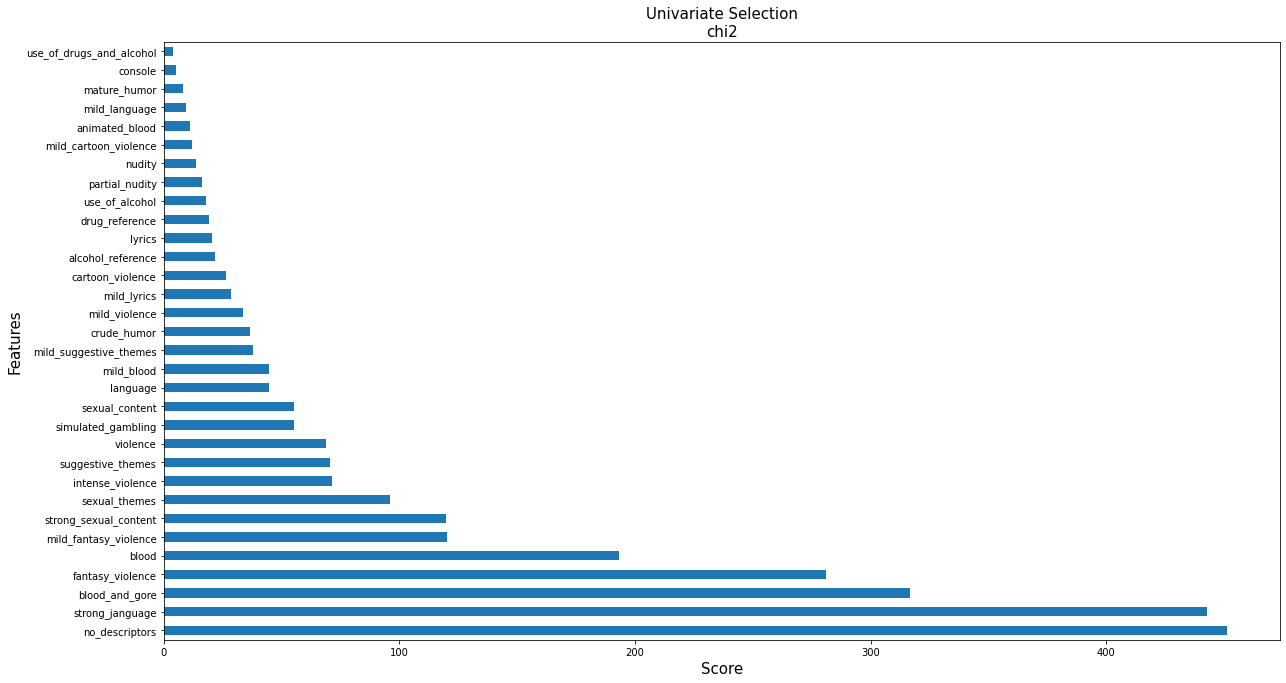

In [95]:
# chi2

# K = Number of top features to select. The "all" option bypasses selection, for use in a parameter search
bestFeatures = SelectKBest(score_func=chi2, k='all')
fit = bestFeatures.fit(X_train,y_train)

# concat two dataframes for better visualization
dfScores = pd.DataFrame(fit.scores_)
dfColumns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([dfColumns,dfScores],axis=1)
featureScores.columns = ['Features','Score']  # naming the dataframe columns
#print(featureScores.nlargest(10,'Score'))  # print 10 best features
print((featureScores.sort_values(by='Score', ascending=False)).to_string(index=False))

featScores = pd.Series(fit.scores_, index=X_train.columns)
featScores.nlargest(32).plot(kind='barh', figsize = (20, 11))
plt.title('Univariate Selection\nchi2', fontsize = 15)
plt.xlabel('Score', fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.show()

                Features      Score
          no_descriptors 347.479771
         strong_janguage 291.850836
          blood_and_gore 181.016975
        fantasy_violence 171.860802
                   blood 106.073823
   mild_fantasy_violence  47.280022
   strong_sexual_content  46.314631
           sexual_themes  37.272320
        intense_violence  28.815800
       suggestive_themes  28.534039
                violence  26.103662
      simulated_gambling  20.690491
          sexual_content  20.053619
                language  17.445843
              mild_blood  16.601968
  mild_suggestive_themes  13.603810
             crude_humor  13.413744
           mild_violence  12.170052
             mild_lyrics  10.446626
        cartoon_violence   9.269325
       alcohol_reference   7.716220
                  lyrics   7.085029
          drug_reference   6.722472
          use_of_alcohol   6.213667
          partial_nudity   5.578026
                  nudity   4.613217
   mild_cartoon_violence   4

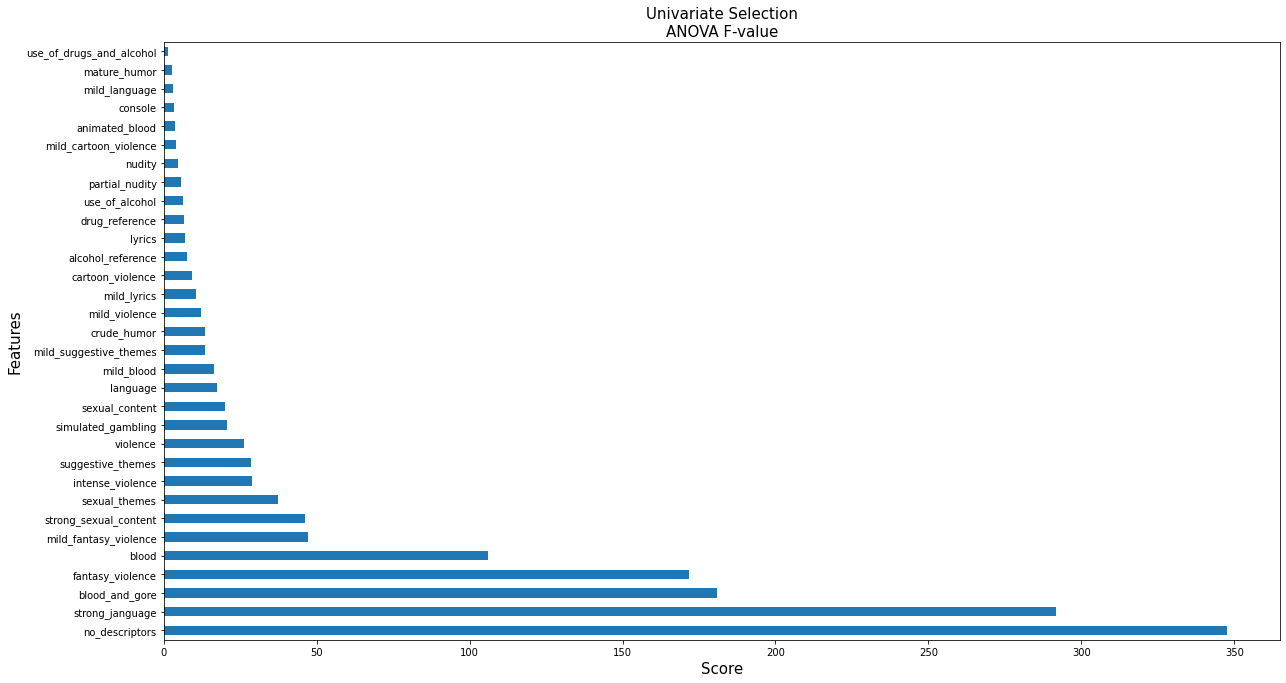

In [110]:
# ANOVA F-value

# K = Number of top features to select. The "all" option bypasses selection, for use in a parameter search
test = SelectKBest(score_func=f_classif, k='all')
fit = test.fit(X_train,y_train)

# summarize scores
np.set_printoptions(precision=3)

# concat two dataframes for better visualization
dfScores = pd.DataFrame(fit.scores_)
dfColumns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([dfColumns,dfScores],axis=1)
featureScores.columns = ['Features','Score']  # naming the dataframe columns
#print(featureScores.nlargest(10,'Score'))  # print 10 best features
print((featureScores.sort_values(by='Score', ascending=False)).to_string(index=False))

featScores = pd.Series(fit.scores_, index=X_train.columns)
featScores.nlargest(32).plot(kind='barh', figsize = (20, 11))
plt.title('Univariate Selection\nANOVA F-value', fontsize = 15)
plt.xlabel('Score', fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.show()

### 2.1.B. Recursive Feature Elimination <a name = "21B"></a>
[Voltar ao Índice](#index)

In [97]:
# LogisticRegression

# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X_train,y_train)

# ranking_: The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature
# Selected (i.e., estimated best) features are assigned rank 1
# support_: The mask of selected features

# concat three dataframes for better visualization
dfRanking = pd.DataFrame(fit.ranking_)
dfSupport = pd.DataFrame(fit.support_)
dfColumns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([dfColumns,dfRanking, dfSupport],axis=1)
featureScores.columns = ['Features','Rank', 'Selected'] # naming the dataframe columns
featureScores.sort_values(by='Rank', ascending=True)

,Features,Rank,Selected
15,mild_fantasy_violence,1,True
27,strong_sexual_content,1,True
26,strong_janguage,1,True
3,blood,1,True
4,blood_and_gore,1,True
25,simulated_gambling,1,True
8,fantasy_violence,1,True
24,sexual_themes,1,True
10,language,1,True
20,no_descriptors,1,True


### 2.1.C. Feature Importance <a name = "21C"></a>
[Voltar ao Índice](#index)

                Features  Importance
          no_descriptors    0.142021
         strong_janguage    0.121010
        fantasy_violence    0.091793
                   blood    0.086526
          blood_and_gore    0.077678
   mild_fantasy_violence    0.040645
       suggestive_themes    0.031689
                violence    0.031549
                language    0.031121
             crude_humor    0.025615
        intense_violence    0.024771
           sexual_themes    0.023869
      simulated_gambling    0.023797
       alcohol_reference    0.023348
                 console    0.022867
   strong_sexual_content    0.021327
           mild_violence    0.021115
              mild_blood    0.020007
  mild_suggestive_themes    0.019219
        cartoon_violence    0.014818
          drug_reference    0.013684
             mild_lyrics    0.013546
          use_of_alcohol    0.011936
                  lyrics    0.011173
   mild_cartoon_violence    0.009734
           mild_language    0.008264
 

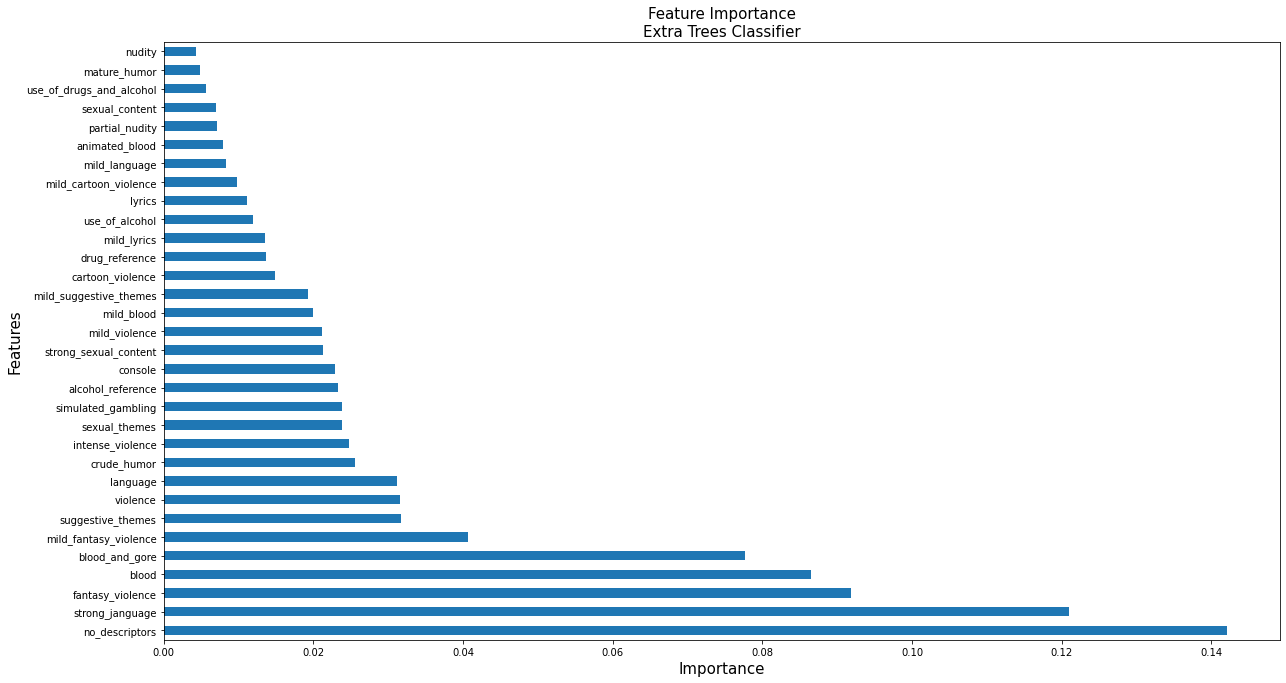

In [111]:
# ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=0)
model.fit(X_train,y_train)

# use inbuilt class feature_importances of tree based classifiers

# concat two dataframes for better visualization 
dfImportances = pd.DataFrame(model.feature_importances_)
dfColumns = pd.DataFrame(X_train.columns)
featureImportances = pd.concat([dfColumns,dfImportances],axis=1)
featureImportances.columns = ['Features','Importance']  # naming the dataframe columns
#print(featureScores.nlargest(10,'Importance'))  # print 10 best features
print((featureImportances.sort_values(by='Importance', ascending=False)).to_string(index=False))

# plot graph of feature importances for better visualization
featImportances = pd.Series(model.feature_importances_, index=X_train.columns)
featImportances.nlargest(32).plot(kind='barh', figsize = (20, 11))
plt.title('Feature Importance\nExtra Trees Classifier', fontsize = 15)
plt.xlabel('Importance', fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.show()

## 2.2. Data Cleaning <a name = "22"></a>
[Voltar ao Índice](#index)

In [75]:
data = pd.read_csv('data/train.csv')

# rename column strong_janguage to strong_language
data.rename(columns={'strong_janguage': 'strong_language'}, inplace=True, errors='raise')

# change esrb_rating to a numeric scale
mapp = {
  'E' : 0,
  'ET': 1,
  'T' : 2,
  'M' : 3
}
data['esrb_rating'] = data['esrb_rating'].map(mapp)

data.to_csv('data/data_prep_out.csv', index=False, header=True)

## 2.3. Data Formatting (Imbalanced Dataset) <a name = "23"></a>
[Voltar ao Índice](#index)

esrb_rating=T, n=415 (36.53%)
esrb_rating=M, n=232 (20.42%)
esrb_rating=E, n=257 (22.62%)
esrb_rating=ET, n=232 (20.42%)


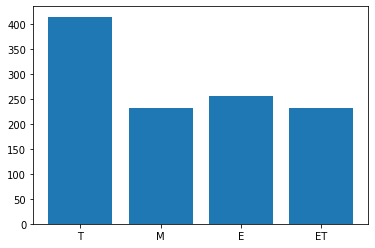

In [116]:
#https://machinelearningmastery.com/multi-class-imbalanced-classification/

# this section is only for demonstration purposes and for better visualization of the distribution of the data,
# as this technique is applied to the training data of each fold at the moment before each model is trained

# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print(f'esrb_rating={k}, n={v} ({round(per,2)}%)')
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

esrb_rating=T, n=415 (25.0%)
esrb_rating=M, n=415 (25.0%)
esrb_rating=E, n=415 (25.0%)
esrb_rating=ET, n=415 (25.0%)


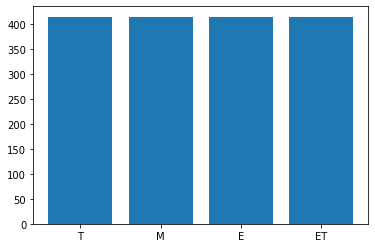

In [117]:
# transform the training data of the first fold (we will apply this technique to each fold in the modeling phase)
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

# summarize distribution
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y_train) * 100
    print(f'esrb_rating={k}, n={v} ({round(per,2)}%)')
    
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

# 3. Data Modeling <a name = "3"></a>
[Voltar ao Índice](#index)

In [2]:
# import data obtained after Data Cleaning
data = pd.read_csv('data/data_prep_out.csv')

# remove id and title
scenery1_data = data.iloc[:,2:35]

scenery2_data = data[['no_descriptors', 'strong_language', 'blood_and_gore', 'fantasy_violence', 'blood',
                      'mild_fantasy_violence', 'strong_sexual_content', 'sexual_themes', 'intense_violence',
                      'suggestive_themes', 'violence', 'simulated_gambling', 'sexual_content', 'language',
                      'mild_blood', 'mild_suggestive_themes', 'crude_humor', 'mild_violence', 'mild_lyrics',
                      'cartoon_violence', 'alcohol_reference', 'lyrics', 'drug_reference', 'use_of_alcohol',
                      'partial_nudity', 'nudity', 'mild_cartoon_violence', 'animated_blood', 'esrb_rating']]
scenery3_data = data[['no_descriptors', 'strong_language', 'blood_and_gore', 'fantasy_violence', 'blood',
                      'mild_fantasy_violence', 'strong_sexual_content', 'sexual_themes', 'intense_violence',
                      'suggestive_themes', 'violence', 'simulated_gambling', 'sexual_content', 'esrb_rating']]

### Load Variables

In [3]:
# Technique for oversampling
oversample = SMOTE(random_state=323)

# StratifiedKFold
skf = StratifiedKFold(n_splits=5)

# Models (Dictionary)
state = 0
models = {
    "SGD_Classifier":{
        "model":SGDClassifier(random_state=state, max_iter=2000, tol=1e-3),
        "params":{
            "loss" : ["log", "modified_huber"],
            "penalty" : ["l2", "l1", "elasticnet"]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "Linear_Discriminant_Analysis":{
        "model":LinearDiscriminantAnalysis(),
        "params":{
            "solver":["svd", "lsqr", "eigen"],
            "store_covariance":[True, False],
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "K_Neighbors_Classifier":{
        "model":KNeighborsClassifier(),
        "params":{
            "n_neighbors" : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            "weights" : ["uniform", "distance"],
            "algorithm" : ["auto", "ball_tree", "kd_tree", "brute"]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "Logistic_Regression":{
        "model":LogisticRegression(random_state=state),
        "params":{
            "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
            "penalty":["l1", "l2", "elasticnet", "none"],
            "dual":[True,False]
            
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "Decision_Tree_Classifier":{
        "model":DecisionTreeClassifier(random_state=state),
        "params":{
            "criterion": ["gini", "entropy"]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "SVC":{
        "model":SVC(random_state=state, probability=True),
        "params":{
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "C": [0.1, 0.01, 0.001, 0.0001, 1, 10, 100],
            "gamma" : [0.1, 1, 10, 100]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "Nu_SVC":{
        "model":NuSVC(random_state=state, probability=True),
        "params":{
            "nu": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "gamma" : [0.1, 1, 10, 100]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "MLP_Classifier":{
        "model":MLPClassifier(random_state=state, max_iter=2000),
        "params":{
            "solver": ["sgd", "adam", "lbfgs"],
            "alpha": [0.0001, 0.05],
            "learning_rate": ["constant", "invscaling","adaptive"]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "Random_Forest_Classifier":{
        "model":RandomForestClassifier(random_state=state),
        "params":{
            "n_estimators": [1, 5, 10, 50, 100, 200, 150, 125],
            "criterion": ["gini", "entropy"]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    },
    "Gradient_Boosting_Classifier":{
        "model":GradientBoostingClassifier(random_state=state, n_estimators=500),
        "params":{
            "learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001],
            "max_depth":[1,3,5,7,9,10,20,50,100],
            "min_samples_split":[2,4,6,8,10,20,40],
            "min_samples_leaf":[1,3,5,7,9]
        },
        "scenery1": {},
        "scenery2": {},
        "scenery3": {}
    }
}

## 3.1. Hyperparameter Tuning <a name = "31"></a>
[Voltar ao Índice](#index)

In [ ]:
# Hyperparameter Tuning
# This cycle takes around 8 hours to complete
# If you are testing this notebook, you can skip this cell and run the following cell
# NOTE: If you are not skipping this cell, you should not run the following cell
for i in range(3):
    scenery = i+1
    if scenery == 1:
        X, y = scenery1_data.iloc[:,0:32], scenery1_data.iloc[:,32]
    if scenery == 2:
        X, y = scenery2_data.iloc[:,0:28], scenery2_data.iloc[:,28]
    if scenery == 3:
        X, y = scenery3_data.iloc[:,0:13], scenery3_data.iloc[:,13]
        
    X_train, y_train = [], []
    for train_index, test_index in skf.split(X, y):
        X_train, y_train = X.loc[train_index], y.loc[train_index]
        break
    
    # Oversampling
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    print("-----------------------------------")
    print(f'Scenery {scenery}')
    print("-----------------------------------")
    for name, model in models.items():
        clf = GridSearchCV(model["model"], model["params"], scoring="accuracy", cv=skf, n_jobs=4)
        clf.fit(X_train, y_train)
    
        # best_score_ and best_params_ are other methods of GridSearchCV
        model[f'scenery{scenery}']["best_estimator"] = clf.best_estimator_

        print(f"models['{name}']['scenery{scenery}']['best_estimator'] = {clf.best_estimator_}")

In [4]:
# load best parameters
# Only if we don't want to run GridSearchCV
#-----------------------------------
#Scenery 1
#-----------------------------------
models['SGD_Classifier']['scenery1']['best_estimator'] = SGDClassifier(loss='log', max_iter=2000, penalty='l1', random_state=0)
models['Linear_Discriminant_Analysis']['scenery1']['best_estimator'] = LinearDiscriminantAnalysis(store_covariance=True)
models['K_Neighbors_Classifier']['scenery1']['best_estimator'] = KNeighborsClassifier(n_neighbors=6, weights='distance')
models['Logistic_Regression']['scenery1']['best_estimator'] = LogisticRegression(penalty='none', random_state=0)
models['Decision_Tree_Classifier']['scenery1']['best_estimator'] = DecisionTreeClassifier(criterion='entropy', random_state=0)
models['SVC']['scenery1']['best_estimator'] = SVC(C=10, gamma=0.1, probability=True, random_state=0)
models['Nu_SVC']['scenery1']['best_estimator'] = NuSVC(gamma=1, nu=0.2, probability=True, random_state=0)
models['MLP_Classifier']['scenery1']['best_estimator'] = MLPClassifier(max_iter=2000, random_state=0)
models['Random_Forest_Classifier']['scenery1']['best_estimator'] = RandomForestClassifier(n_estimators=50, random_state=0)
models['Gradient_Boosting_Classifier']['scenery1']['best_estimator'] = GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3,
                           min_samples_split=8, n_estimators=500,
                           random_state=0)
#-----------------------------------
#Scenery 2
#-----------------------------------
models['SGD_Classifier']['scenery2']['best_estimator'] = SGDClassifier(loss='log', max_iter=2000, penalty='l1', random_state=0)
models['Linear_Discriminant_Analysis']['scenery2']['best_estimator'] = LinearDiscriminantAnalysis(store_covariance=True)
models['K_Neighbors_Classifier']['scenery2']['best_estimator'] = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')
models['Logistic_Regression']['scenery2']['best_estimator'] = LogisticRegression(penalty='none', random_state=0, solver='saga')
models['Decision_Tree_Classifier']['scenery2']['best_estimator'] = DecisionTreeClassifier(criterion='entropy', random_state=0)
models['SVC']['scenery2']['best_estimator'] = SVC(C=10, gamma=0.1, probability=True, random_state=0)
models['Nu_SVC']['scenery2']['best_estimator'] = NuSVC(gamma=0.1, nu=0.2, probability=True, random_state=0)
models['MLP_Classifier']['scenery2']['best_estimator'] = MLPClassifier(alpha=0.05, max_iter=2000, random_state=0, solver='lbfgs')
models['Random_Forest_Classifier']['scenery2']['best_estimator'] = RandomForestClassifier(criterion='entropy', n_estimators=150, random_state=0)
models['Gradient_Boosting_Classifier']['scenery2']['best_estimator'] = GradientBoostingClassifier(learning_rate=0.15, max_depth=7,
                           min_samples_split=40, n_estimators=500,
                           random_state=0)
#-----------------------------------
#Scenery 3
#-----------------------------------
models['SGD_Classifier']['scenery3']['best_estimator'] = SGDClassifier(loss='log', max_iter=2000, penalty='l1', random_state=0)
models['Linear_Discriminant_Analysis']['scenery3']['best_estimator'] = LinearDiscriminantAnalysis(store_covariance=True)
models['K_Neighbors_Classifier']['scenery3']['best_estimator'] = KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='distance')
models['Logistic_Regression']['scenery3']['best_estimator'] = LogisticRegression(penalty='none', random_state=0, solver='newton-cg')
models['Decision_Tree_Classifier']['scenery3']['best_estimator'] = DecisionTreeClassifier(criterion='entropy', random_state=0)
models['SVC']['scenery3']['best_estimator'] = SVC(C=0.1, gamma=10, kernel='poly', probability=True, random_state=0)
models['Nu_SVC']['scenery3']['best_estimator'] = NuSVC(gamma=1, nu=0.3, probability=True, random_state=0)
models['MLP_Classifier']['scenery3']['best_estimator'] = MLPClassifier(alpha=0.05, max_iter=2000, random_state=0, solver='lbfgs')
models['Random_Forest_Classifier']['scenery3']['best_estimator'] = RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=0)
models['Gradient_Boosting_Classifier']['scenery3']['best_estimator'] = GradientBoostingClassifier(learning_rate=0.15, min_samples_split=20,
                           n_estimators=500, random_state=0)

In [5]:
def get_best_params(scenery_number):
    models_result = []
    
    for name, model in models.items():
        lst = [name, model[f'scenery{scenery_number}']['best_estimator']]
        models_result.append(lst)

    table = pd.DataFrame(models_result, columns = ['Model', 'Best Estimator (Function + Parameters)'])
    table = table.style.set_properties(subset=['Best Estimator (Function + Parameters)'], **{'width': '700px'}).set_properties(**{'text-align': 'left'}).hide_index()
    display(table)

In [6]:
print('-----------------------------------\nScenery 1\n-----------------------------------')
get_best_params(1)
print('-----------------------------------\nScenery 2\n-----------------------------------')
get_best_params(2)
print('-----------------------------------\nScenery 3\n-----------------------------------')
get_best_params(3)

-----------------------------------
Scenery 1
-----------------------------------


Model,Best Estimator (Function + Parameters)
SGD_Classifier,"SGDClassifier(loss='log', max_iter=2000, penalty='l1', random_state=0)"
Linear_Discriminant_Analysis,LinearDiscriminantAnalysis(store_covariance=True)
K_Neighbors_Classifier,"KNeighborsClassifier(n_neighbors=6, weights='distance')"
Logistic_Regression,"LogisticRegression(penalty='none', random_state=0)"
Decision_Tree_Classifier,"DecisionTreeClassifier(criterion='entropy', random_state=0)"
SVC,"SVC(C=10, gamma=0.1, probability=True, random_state=0)"
Nu_SVC,"NuSVC(gamma=1, nu=0.2, probability=True, random_state=0)"
MLP_Classifier,"MLPClassifier(max_iter=2000, random_state=0)"
Random_Forest_Classifier,"RandomForestClassifier(n_estimators=50, random_state=0)"
Gradient_Boosting_Classifier,"GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=3, min_samples_split=8, n_estimators=500, random_state=0)"


-----------------------------------
Scenery 2
-----------------------------------


Model,Best Estimator (Function + Parameters)
SGD_Classifier,"SGDClassifier(loss='log', max_iter=2000, penalty='l1', random_state=0)"
Linear_Discriminant_Analysis,LinearDiscriminantAnalysis(store_covariance=True)
K_Neighbors_Classifier,"KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9, weights='distance')"
Logistic_Regression,"LogisticRegression(penalty='none', random_state=0, solver='saga')"
Decision_Tree_Classifier,"DecisionTreeClassifier(criterion='entropy', random_state=0)"
SVC,"SVC(C=10, gamma=0.1, probability=True, random_state=0)"
Nu_SVC,"NuSVC(gamma=0.1, nu=0.2, probability=True, random_state=0)"
MLP_Classifier,"MLPClassifier(alpha=0.05, max_iter=2000, random_state=0, solver='lbfgs')"
Random_Forest_Classifier,"RandomForestClassifier(criterion='entropy', n_estimators=150, random_state=0)"
Gradient_Boosting_Classifier,"GradientBoostingClassifier(learning_rate=0.15, max_depth=7, min_samples_split=40, n_estimators=500, random_state=0)"


-----------------------------------
Scenery 3
-----------------------------------


Model,Best Estimator (Function + Parameters)
SGD_Classifier,"SGDClassifier(loss='log', max_iter=2000, penalty='l1', random_state=0)"
Linear_Discriminant_Analysis,LinearDiscriminantAnalysis(store_covariance=True)
K_Neighbors_Classifier,"KNeighborsClassifier(algorithm='brute', n_neighbors=7, weights='distance')"
Logistic_Regression,"LogisticRegression(penalty='none', random_state=0, solver='newton-cg')"
Decision_Tree_Classifier,"DecisionTreeClassifier(criterion='entropy', random_state=0)"
SVC,"SVC(C=0.1, gamma=10, kernel='poly', probability=True, random_state=0)"
Nu_SVC,"NuSVC(gamma=1, nu=0.3, probability=True, random_state=0)"
MLP_Classifier,"MLPClassifier(alpha=0.05, max_iter=2000, random_state=0, solver='lbfgs')"
Random_Forest_Classifier,"RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=0)"
Gradient_Boosting_Classifier,"GradientBoostingClassifier(learning_rate=0.15, min_samples_split=20, n_estimators=500, random_state=0)"


## 3.2. Apply Stratified K-Folds Cross Validation <a name = "32"></a>
[Voltar ao Índice](#index)

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

# Cross Validation (5 Stratified K-Folds)
for i in range(3):
    scenery = i+1
    
    print(f'-----------------------------------\nScenery {scenery}\n-----------------------------------')
    
    # Get scenery data
    if scenery == 1:
        X, y = scenery1_data.iloc[:,0:32], scenery1_data.iloc[:,32]
    if scenery == 2:
        X, y = scenery2_data.iloc[:,0:28], scenery2_data.iloc[:,28]
    if scenery == 3:
        X, y = scenery3_data.iloc[:,0:13], scenery3_data.iloc[:,13]

    for name, m in models.items():
        model = m[f'scenery{scenery}']['best_estimator']
        
        all_ytest = []
        all_preds = []
        
        acc_scores = []
        rec_scores = []
        prec_scores = []
        f1_scores = []
        training_time = 0

        roc_fprs = []
        roc_tprs = []
        roc_aucs = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            all_ytest.append(y_test)

            # Oversampling
            X_train, y_train = oversample.fit_resample(X_train, y_train)

            start = perf_counter()
            # Model training
            model.fit(X_train, y_train)
            #
            duration = perf_counter() - start
            duration = duration
            training_time += duration

            # Predictions
            pred = model.predict(X_test)
            all_preds.append(pred)
            pred_proba = model.predict_proba(X_test)

            # Accuracy
            acc = accuracy_score(y_test, pred)
            acc_scores.append(acc)
            
            # Recall
            rec = recall_score(y_test, pred, average='weighted')
            rec_scores.append(rec)

            # Precision
            prec = precision_score(y_test, pred, average='weighted')
            prec_scores.append(prec)
            
            # F1
            f1 = f1_score(y_test, pred, average='weighted')
            f1_scores.append(f1)

            # ROC
            fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1], pos_label=1)
            roc_tprs.append(tpr)
            roc_fprs.append(fpr)
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)


        m[f'scenery{scenery}']['all_ytest'] = all_ytest
        m[f'scenery{scenery}']['all_preds'] = all_preds
        
        m[f'scenery{scenery}']['acc_scores'] = acc_scores
        m[f'scenery{scenery}']['f1_scores'] = f1_scores
        m[f'scenery{scenery}']['prec_scores'] = prec_scores
        m[f'scenery{scenery}']['rec_scores'] = rec_scores
        m[f'scenery{scenery}']['training_time'] = round(training_time,3)

        m[f'scenery{scenery}']['roc_fprs'] = roc_fprs
        m[f'scenery{scenery}']['roc_tprs'] = roc_tprs
        m[f'scenery{scenery}']['roc_aucs'] = roc_aucs

        print(f"{name:30} -> acc: {round(np.mean(acc_scores),5)}; rec: {round(np.mean(rec_scores),5)}; " +
              f"prec: {round(np.mean(prec_scores),5)}; f1: {round(np.mean(f1_scores),5)}; " +
              f"trained in {round(training_time,3)}s")

-----------------------------------
Scenery 1
-----------------------------------
SGD_Classifier                 -> acc: 0.84729; rec: 0.84729; prec: 0.84806; f1: 0.84678; trained in 0.218s
Linear_Discriminant_Analysis   -> acc: 0.79099; rec: 0.79099; prec: 0.79999; f1: 0.79087; trained in 0.078s
K_Neighbors_Classifier         -> acc: 0.81842; rec: 0.81842; prec: 0.8245; f1: 0.8159; trained in 0.015s
Logistic_Regression            -> acc: 0.85996; rec: 0.85996; prec: 0.86183; f1: 0.85969; trained in 0.35s
Decision_Tree_Classifier       -> acc: 0.8325; rec: 0.8325; prec: 0.83432; f1: 0.83145; trained in 0.029s
SVC                            -> acc: 0.85996; rec: 0.85996; prec: 0.86077; f1: 0.85962; trained in 1.294s
Nu_SVC                         -> acc: 0.84869; rec: 0.84869; prec: 0.85134; f1: 0.84928; trained in 2.59s
MLP_Classifier                 -> acc: 0.86136; rec: 0.86136; prec: 0.86242; f1: 0.86118; trained in 21.181s
Random_Forest_Classifier       -> acc: 0.84446; rec: 0.8444

# 4. Evaluation <a name = "4"></a>

## 4.1. Results <a name = "41"></a>
[Voltar ao Índice](#index)

In [26]:
def get_results(scenery_number, show=True, path=False):

    models_result = []

    for name, model in models.items():
        scenery = model[f'scenery{scenery_number}']
        acc_scores = scenery['acc_scores']
        rec_scores = scenery['rec_scores']
        prec_scores = scenery['prec_scores']
        f1_scores = scenery['f1_scores']
        roc_aucs = scenery['roc_aucs']
        training_time = scenery['training_time']
        lst = [name, f'{round(np.mean(acc_scores),5)} ± {round(np.std(acc_scores),3)}', f'{round(np.mean(rec_scores),5)} ± {round(np.std(rec_scores),3)}', f'{round(np.mean(prec_scores),5)} ± {round(np.std(prec_scores),3)}', f'{round(np.mean(f1_scores),5)} ± {round(np.std(f1_scores),3)}', f'{round(np.mean(roc_aucs),5)} ± {round(np.std(roc_aucs),3)}', f'{training_time}']
        models_result.append(lst)

    table = pd.DataFrame(models_result, columns = ['Model', 'Accuracy (Mean ± STD)', 'Recall (Mean ± STD)', 'Precision (Mean ± STD)', 'F1 (Mean ± STD)', 'ROC AUC (Mean ± STD)', 'Training Time (sec)'])
    table.sort_values(by='Accuracy (Mean ± STD)', ascending=False, inplace=True)
    #table.reset_index(inplace=True,drop=True)
    if show:
        display(table.style.set_properties(**{'text-align': 'left'}).hide_index())   
    if path:
        fig,ax = render_mpl_table(table, header_color='#0070C0', header_columns=1, col_width=4.8)
        fig.savefig(f"{path}.png")
    return table
    
def get_results_plot(scenery_number, title, ylabel, metric, sort_by):
    models_result = []

    for name, model in models.items():
        scenery = model[f'scenery{scenery_number}']
        acc_scores = scenery['acc_scores']
        rec_scores = scenery['rec_scores']
        prec_scores = scenery['prec_scores']
        f1_scores = scenery['f1_scores']
        roc_aucs = scenery['roc_aucs']
        training_time = scenery['training_time']
        lst = [name, np.mean(acc_scores), np.mean(rec_scores), np.mean(prec_scores), np.mean(f1_scores), np.mean(roc_aucs), training_time]
        models_result.append(lst)
    
    table = pd.DataFrame(models_result, columns = ['model', 'accuracy', 'recall', 'precision', 'f1', 'roc', 'training_time'])
    table.sort_values(by=sort_by, ascending=False, inplace=True)
    plt.figure(figsize = (15,5))
    sns.barplot(x = 'model', y = metric, data = table)
    plt.title(title, fontsize = 15)
    if metric != 'training_time':
        plt.ylim(0,1)
    plt.xlabel('Model', fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.xticks(rotation=90, fontsize=12)
    plt.show()
    
#https://stackoverflow.com/questions/19726663/how-to-save-the-pandas-dataframe-series-data-as-a-figure
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs, cellLoc='left')
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [27]:
print('-----------------------------------\nScenery 1\n-----------------------------------')
get_results(1)
print('-----------------------------------\nScenery 2\n-----------------------------------')
get_results(2)
print('-----------------------------------\nScenery 3\n-----------------------------------')
get_results(3)
print('-----------------------------------')

-----------------------------------
Scenery 1
-----------------------------------


Model,Accuracy (Mean ± STD),Recall (Mean ± STD),Precision (Mean ± STD),F1 (Mean ± STD),ROC AUC (Mean ± STD),Training Time (sec)
Gradient_Boosting_Classifier,0.86136 ± 0.008,0.86136 ± 0.008,0.86196 ± 0.008,0.86108 ± 0.008,0.95974 ± 0.012,15.914
MLP_Classifier,0.86136 ± 0.007,0.86136 ± 0.007,0.86242 ± 0.008,0.86118 ± 0.007,0.95822 ± 0.007,21.181
Logistic_Regression,0.85996 ± 0.007,0.85996 ± 0.007,0.86183 ± 0.008,0.85969 ± 0.007,0.95519 ± 0.011,0.35
SVC,0.85996 ± 0.007,0.85996 ± 0.007,0.86077 ± 0.008,0.85962 ± 0.007,0.95891 ± 0.011,1.294
Nu_SVC,0.84869 ± 0.008,0.84869 ± 0.008,0.85134 ± 0.007,0.84928 ± 0.008,0.94177 ± 0.015,2.59
SGD_Classifier,0.84729 ± 0.009,0.84729 ± 0.009,0.84806 ± 0.008,0.84678 ± 0.008,0.95292 ± 0.009,0.218
Random_Forest_Classifier,0.84446 ± 0.014,0.84446 ± 0.014,0.84513 ± 0.015,0.84355 ± 0.014,0.95597 ± 0.014,0.426
Decision_Tree_Classifier,0.8325 ± 0.011,0.8325 ± 0.011,0.83432 ± 0.012,0.83145 ± 0.012,0.90826 ± 0.035,0.029
K_Neighbors_Classifier,0.81842 ± 0.019,0.81842 ± 0.019,0.8245 ± 0.02,0.8159 ± 0.02,0.92604 ± 0.017,0.015
Linear_Discriminant_Analysis,0.79099 ± 0.01,0.79099 ± 0.01,0.79999 ± 0.011,0.79087 ± 0.01,0.93003 ± 0.018,0.078


-----------------------------------
Scenery 2
-----------------------------------


Model,Accuracy (Mean ± STD),Recall (Mean ± STD),Precision (Mean ± STD),F1 (Mean ± STD),ROC AUC (Mean ± STD),Training Time (sec)
MLP_Classifier,0.87544 ± 0.011,0.87544 ± 0.011,0.87696 ± 0.01,0.87533 ± 0.01,0.96094 ± 0.006,16.566
SVC,0.86771 ± 0.007,0.86771 ± 0.007,0.8682 ± 0.007,0.86732 ± 0.007,0.96394 ± 0.006,1.212
Logistic_Regression,0.86278 ± 0.01,0.86278 ± 0.01,0.86445 ± 0.01,0.86221 ± 0.01,0.95873 ± 0.01,0.646
Gradient_Boosting_Classifier,0.86277 ± 0.016,0.86277 ± 0.016,0.86481 ± 0.015,0.86259 ± 0.015,0.95372 ± 0.013,28.964
Nu_SVC,0.86277 ± 0.006,0.86277 ± 0.006,0.86364 ± 0.006,0.86253 ± 0.006,0.95396 ± 0.011,2.25
Random_Forest_Classifier,0.85925 ± 0.013,0.85925 ± 0.013,0.86173 ± 0.014,0.85874 ± 0.013,0.96057 ± 0.009,1.3
Decision_Tree_Classifier,0.85151 ± 0.013,0.85151 ± 0.013,0.85421 ± 0.013,0.85093 ± 0.012,0.92079 ± 0.023,0.02
SGD_Classifier,0.84589 ± 0.005,0.84589 ± 0.005,0.84665 ± 0.005,0.84532 ± 0.005,0.95475 ± 0.01,0.183
K_Neighbors_Classifier,0.84236 ± 0.009,0.84236 ± 0.009,0.84509 ± 0.01,0.84163 ± 0.009,0.94288 ± 0.017,0.028
Linear_Discriminant_Analysis,0.79029 ± 0.009,0.79029 ± 0.009,0.80206 ± 0.008,0.79131 ± 0.008,0.93224 ± 0.019,0.063


-----------------------------------
Scenery 3
-----------------------------------


Model,Accuracy (Mean ± STD),Recall (Mean ± STD),Precision (Mean ± STD),F1 (Mean ± STD),ROC AUC (Mean ± STD),Training Time (sec)
K_Neighbors_Classifier,0.78606 ± 0.011,0.78606 ± 0.011,0.81095 ± 0.007,0.78439 ± 0.009,0.922 ± 0.012,0.009
SVC,0.78327 ± 0.019,0.78327 ± 0.019,0.81403 ± 0.008,0.78345 ± 0.018,0.90743 ± 0.01,0.719
Nu_SVC,0.78186 ± 0.012,0.78186 ± 0.012,0.81266 ± 0.009,0.78157 ± 0.011,0.92821 ± 0.009,2.855
SGD_Classifier,0.78113 ± 0.02,0.78113 ± 0.02,0.80255 ± 0.025,0.78026 ± 0.024,0.93905 ± 0.013,0.163
MLP_Classifier,0.78045 ± 0.016,0.78045 ± 0.016,0.81093 ± 0.008,0.78068 ± 0.015,0.93967 ± 0.012,16.931
Random_Forest_Classifier,0.78045 ± 0.015,0.78045 ± 0.015,0.81228 ± 0.01,0.78027 ± 0.013,0.9421 ± 0.012,1.473
Gradient_Boosting_Classifier,0.77974 ± 0.015,0.77974 ± 0.015,0.81216 ± 0.012,0.78003 ± 0.014,0.93684 ± 0.017,12.03
Logistic_Regression,0.77763 ± 0.012,0.77763 ± 0.012,0.80834 ± 0.011,0.77747 ± 0.009,0.93966 ± 0.012,0.59
Decision_Tree_Classifier,0.77552 ± 0.014,0.77552 ± 0.014,0.81031 ± 0.007,0.7753 ± 0.012,0.9358 ± 0.013,0.022
Linear_Discriminant_Analysis,0.76708 ± 0.019,0.76708 ± 0.019,0.805 ± 0.013,0.76793 ± 0.019,0.92149 ± 0.021,0.04


-----------------------------------


-----------------------------------


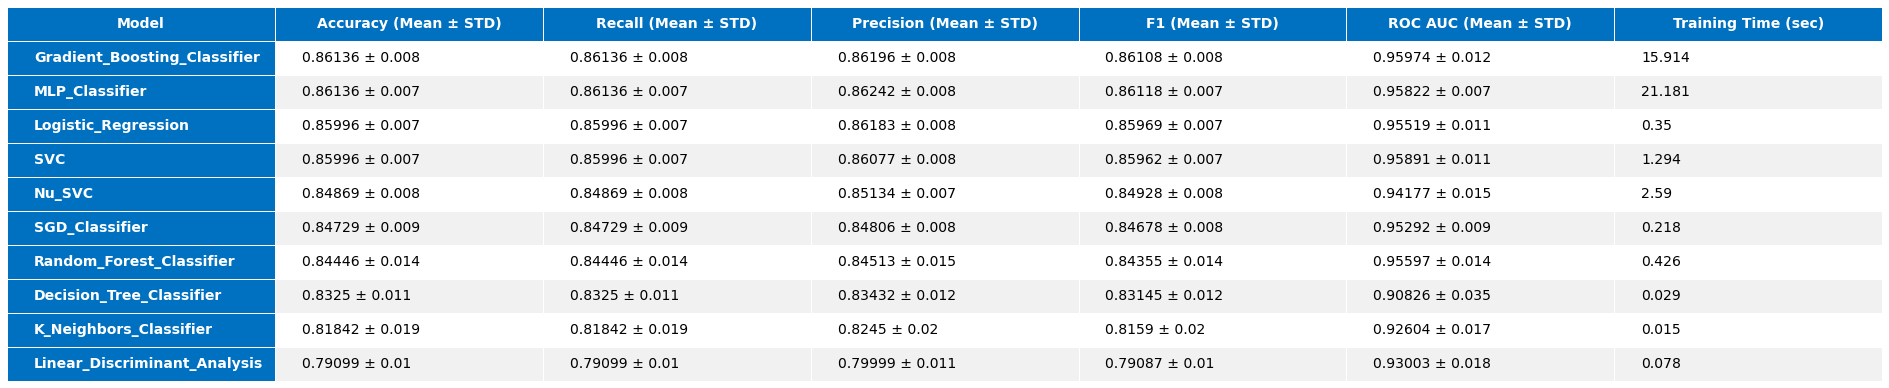

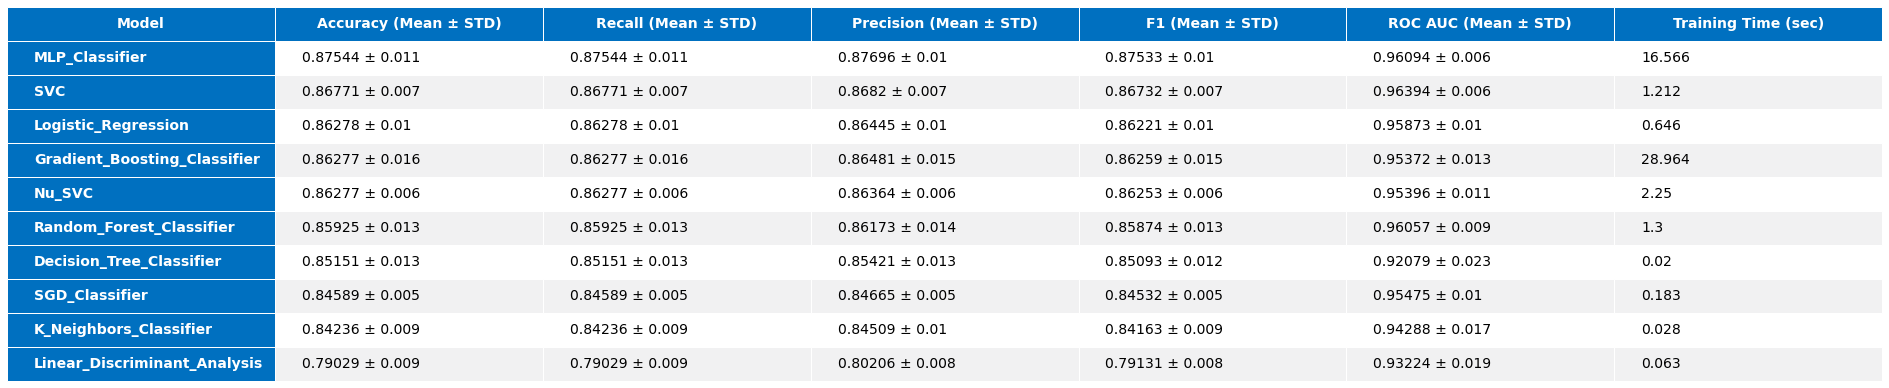

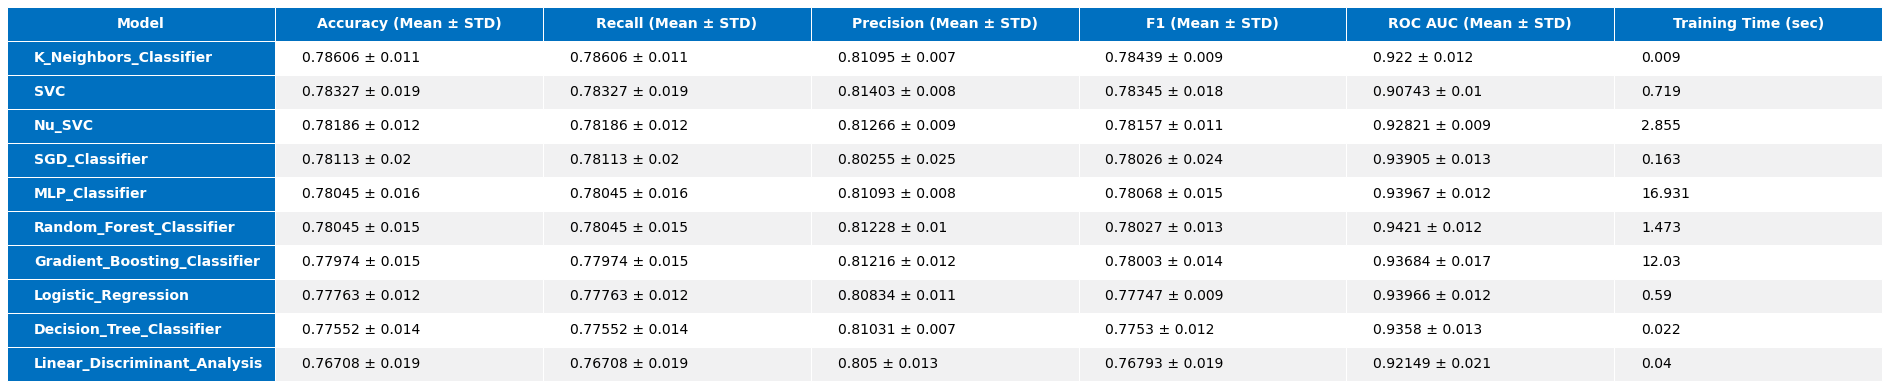

In [28]:
# Save results
get_results(1, show=False, path="images/results_scenery1")
get_results(2, show=False, path="images/results_scenery2")
get_results(3, show=False, path="images/results_scenery3")
print('-----------------------------------')

-----------------------------------
Scenery 1
-----------------------------------


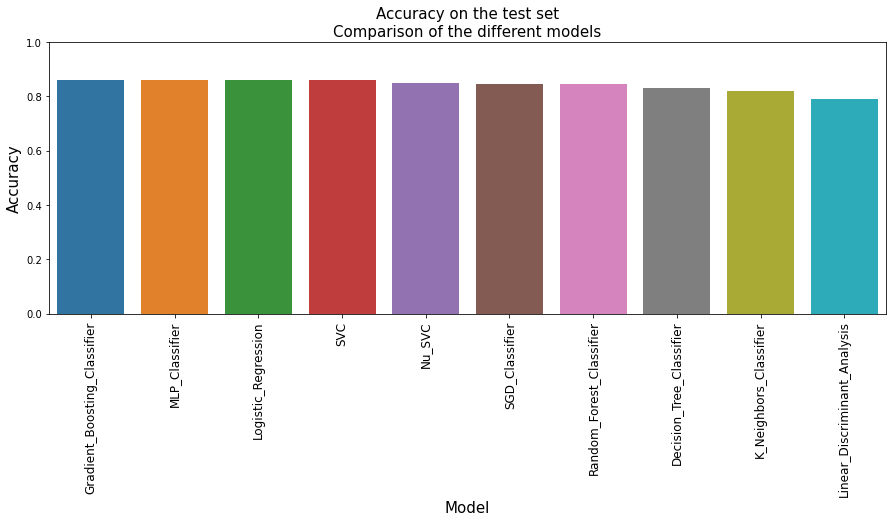

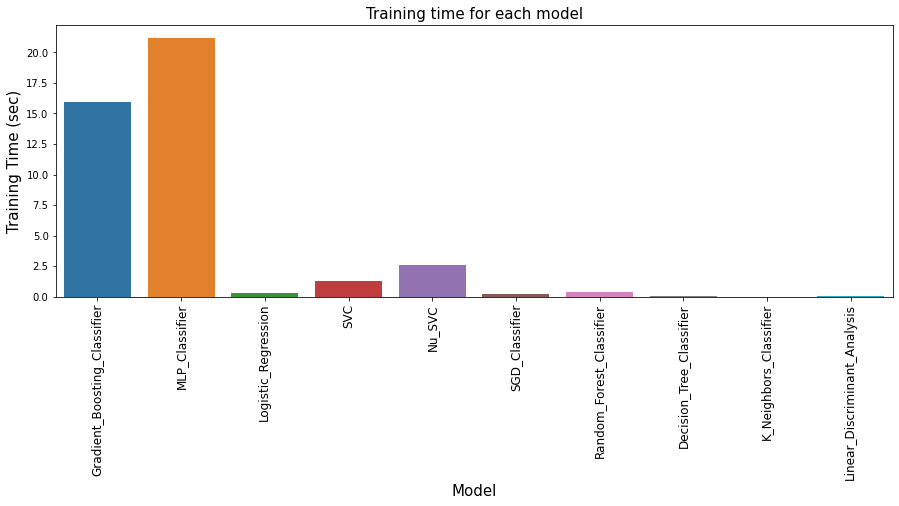

-----------------------------------
Scenery 2
-----------------------------------


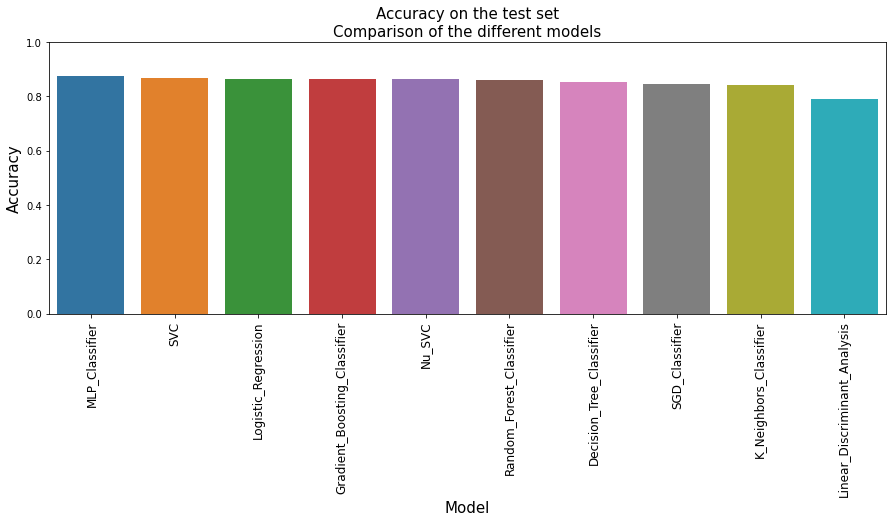

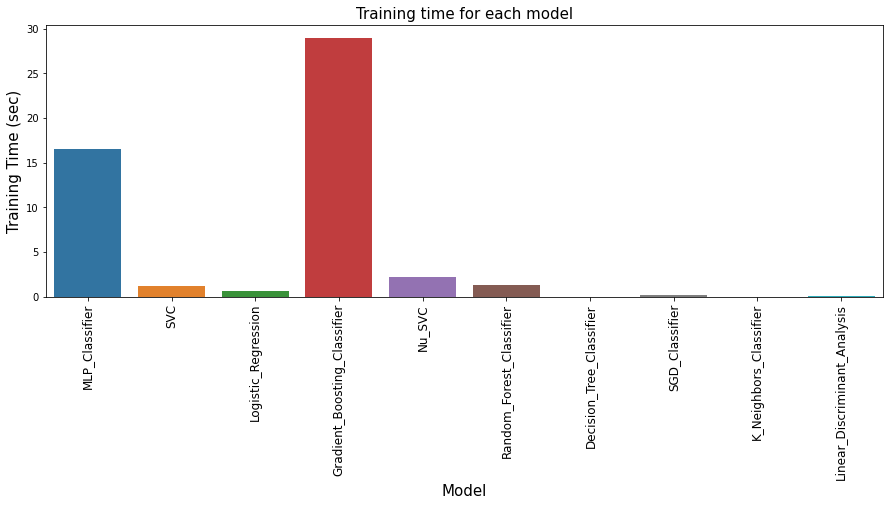

-----------------------------------
Scenery 3
-----------------------------------


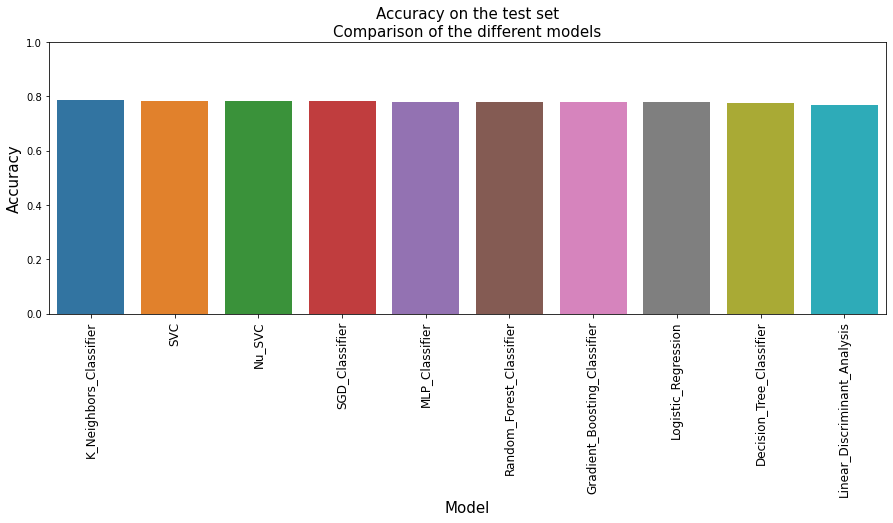

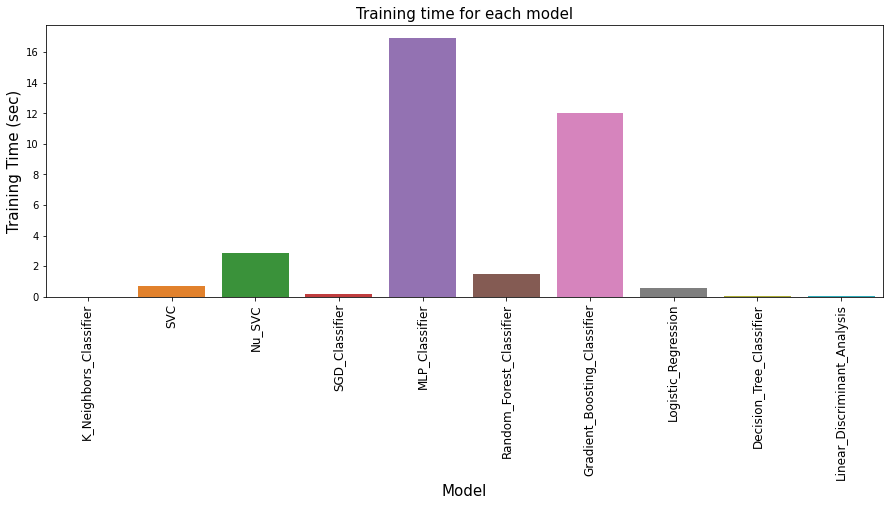

In [29]:
# plot the decision metric
print('-----------------------------------\nScenery 1\n-----------------------------------')
get_results_plot(1, "Accuracy on the test set\nComparison of the different models", "Accuracy", "accuracy", "accuracy")
get_results_plot(1, "Training time for each model", "Training Time (sec)", "training_time", "accuracy")
print('-----------------------------------\nScenery 2\n-----------------------------------')
get_results_plot(2, "Accuracy on the test set\nComparison of the different models", "Accuracy", "accuracy", "accuracy")
get_results_plot(2, "Training time for each model", "Training Time (sec)", "training_time", "accuracy")
print('-----------------------------------\nScenery 3\n-----------------------------------')
get_results_plot(3, "Accuracy on the test set\nComparison of the different models", "Accuracy", "accuracy", "accuracy")
get_results_plot(3, "Training time for each model", "Training Time (sec)", "training_time", "accuracy")

## 4.2. Confusion Matrix <a name = "42"></a>
[Voltar ao Índice](#index)

In [12]:
def get_confusion_matrix(all_ytest, all_preds):
    for i in range(len(all_ytest)):
        print(f'-----------------------------------\nFold {i+1}\n-----------------------------------')
        cf_matrix = confusion_matrix(all_ytest[i], all_preds[i])
        plt.figure(figsize = (7,5))
        sns.heatmap(cf_matrix, annot=True, xticklabels = ["E", "ET", "T", "M"], yticklabels = ["E", "ET", "T", "M"], cbar=True, fmt="g")
        #plt.title('Confusion Matrix', fontsize = 23)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.show()

## 4.3. ROC Curve <a name = "43"></a>
[Voltar ao Índice](#index)

In [22]:
#https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv
def get_roc(title, model, fprs, tprs, aucs):
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # plot arrows
    fig1 = plt.figure(figsize=[12,12])
    ax1 = fig1.add_subplot(111,aspect = 'equal')
    ax1.add_patch(patches.Arrow(0.45,0.5,-0.17,0.17,width=0.20,color='green',alpha = 0.5))
    ax1.add_patch(patches.Arrow(0.5,0.45,0.17,-0.17,width=0.20,color='red',alpha = 0.5))

    for i in range(len(tprs)):
        plt.plot(fprs[i], tprs[i], lw=2, alpha=0.3, label=f'ROC fold {i+1} (AUC = {round(aucs[i],5)})')
    
    mean_tpr = []
    mean_fpr = []
    # since each array of tprs and fprs of each fold has different shapes,
    # we will calculate the averages of the values by index to visualize the average ROC curve
    # to visualize the average ROC curve (this is just an approximation of the real curve)
    # NOTE: This is just an approximation!!! 
    #       Since the arrays do not have the same shape it is impossible to create the real mean curve
    #       Also, as this is only for visualization purposes,
    #       the actual values of the AUCs remain the same, not influencing the evaluation process
    for i in range(max([len(tprs[0]), len(tprs[1]), len(tprs[2]), len(tprs[3]), len(tprs[4])])):
        # values by index
        tpr_values = []
        fpr_values = []
        if (i < len(tprs[0])):
            tpr_values.append(tprs[0][i])
            fpr_values.append(fprs[0][i])
        if (i < len(tprs[1])):
            tpr_values.append(tprs[1][i])
            fpr_values.append(fprs[1][i])
        if (i < len(tprs[2])):
            tpr_values.append(tprs[2][i])
            fpr_values.append(fprs[2][i])
        if (i < len(tprs[3])):
            tpr_values.append(tprs[3][i])
            fpr_values.append(fprs[3][i])
        if (i < len(tprs[4])):
            tpr_values.append(tprs[4][i])
            fpr_values.append(fprs[4][i])
        mean_tpr.append(np.mean(tpr_values))
        mean_fpr.append(np.mean(fpr_values))
    
    sorted_index = np.argsort(mean_fpr)
    mean_fpr =  np.array(mean_fpr)[sorted_index]
    mean_tpr = np.array(mean_tpr)[sorted_index]
    
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    plt.plot(mean_fpr, mean_tpr, color='blue',lw=2, alpha=1, label=f'Mean ROC (AUC = {round(mean_auc,5)} ± {round(std_auc,3)} )')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.grid()
    plt.show()
    
def get_roc_means(scenery_number):
    # plot arrows
    fig1 = plt.figure(figsize=[12,12])
    ax1 = fig1.add_subplot(111,aspect = 'equal')
    ax1.add_patch(patches.Arrow(0.45,0.5,-0.17,0.17,width=0.20,color='green',alpha = 0.5))
    ax1.add_patch(patches.Arrow(0.5,0.45,0.17,-0.17,width=0.20,color='red',alpha = 0.5))
    
    for name, model in models.items():
        scenery = model[f'scenery{scenery_number}']
        fprs = scenery['roc_fprs']
        tprs = scenery['roc_tprs']
        aucs = scenery['roc_aucs']

        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)

        mean_tpr = []
        mean_fpr = []
        # since each array of tprs and fprs of each fold has different shapes,
        # we will calculate the averages of the values by index to visualize the average ROC curve
        # to visualize the average ROC curve (this is just an approximation of the real curve)
        # NOTE: This is just an approximation!!! 
        #       Since the arrays do not have the same shape it is impossible to create the real mean curve
        #       Also, as this is only for visualization purposes,
        #       the actual values of the AUCs remain the same, not influencing the evaluation process
        for i in range(max([len(tprs[0]), len(tprs[1]), len(tprs[2]), len(tprs[3]), len(tprs[4])])):
            # values by index
            tpr_values = []
            fpr_values = []
            if (i < len(tprs[0])):
                tpr_values.append(tprs[0][i])
                fpr_values.append(fprs[0][i])
            if (i < len(tprs[1])):
                tpr_values.append(tprs[1][i])
                fpr_values.append(fprs[1][i])
            if (i < len(tprs[2])):
                tpr_values.append(tprs[2][i])
                fpr_values.append(fprs[2][i])
            if (i < len(tprs[3])):
                tpr_values.append(tprs[3][i])
                fpr_values.append(fprs[3][i])
            if (i < len(tprs[4])):
                tpr_values.append(tprs[4][i])
                fpr_values.append(fprs[4][i])
            mean_tpr.append(np.mean(tpr_values))
            mean_fpr.append(np.mean(fpr_values))

        sorted_index = np.argsort(mean_fpr)
        mean_fpr =  np.array(mean_fpr)[sorted_index]
        mean_tpr = np.array(mean_tpr)[sorted_index]

        plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
        plt.plot(mean_fpr, mean_tpr, lw=2, alpha=0.3, label=f'{name} (AUC = {round(mean_auc,5)} ± {round(std_auc,3)} )')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Means - Scenery {scenery_number}')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.grid()
    plt.show()

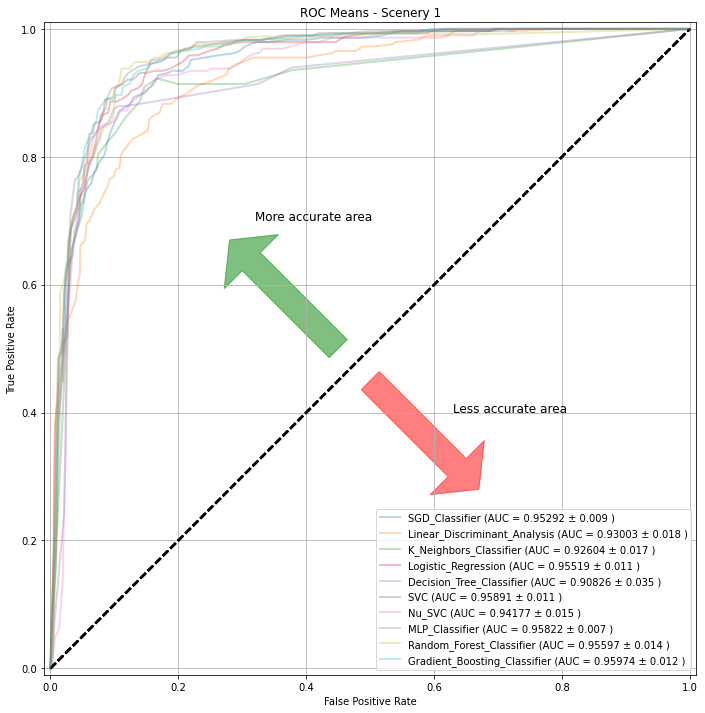

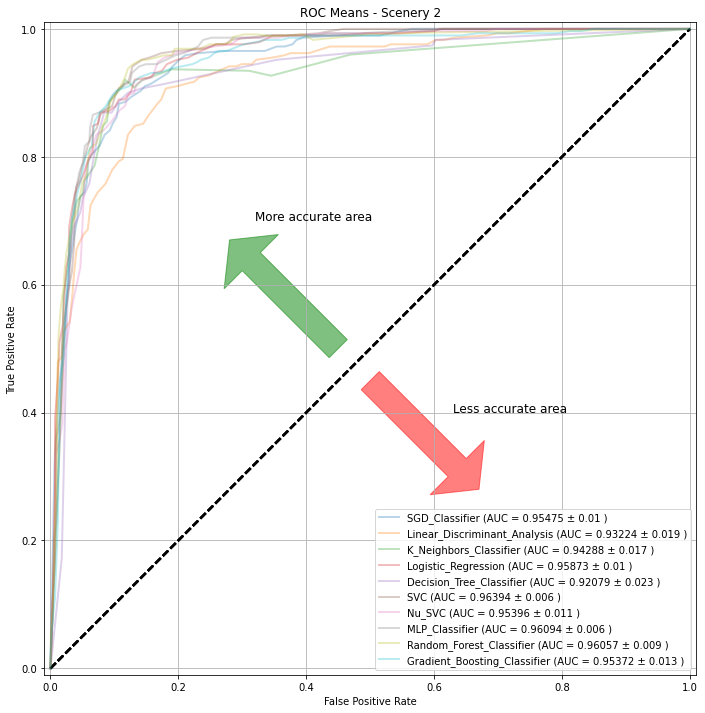

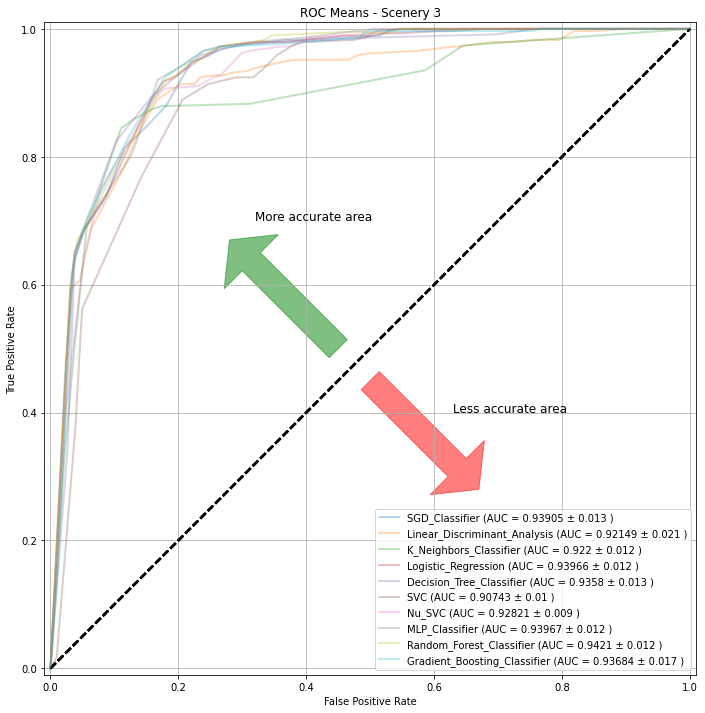

In [23]:
get_roc_means(1)
get_roc_means(2)
get_roc_means(3)

## 4.4. Best Scenery (Number 2) <a name = "44"></a>

### 4.4.1. Best Model (MLP Classifier) <a name = "441"></a>
[Voltar ao Índice](#index)

-----------------------------------
Fold 1
-----------------------------------


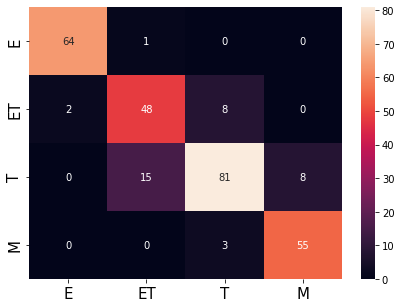

-----------------------------------
Fold 2
-----------------------------------


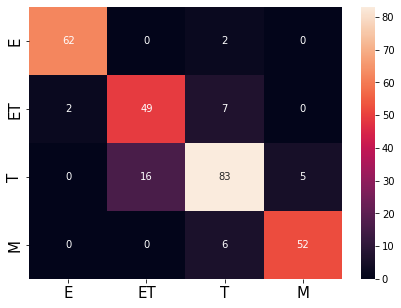

-----------------------------------
Fold 3
-----------------------------------


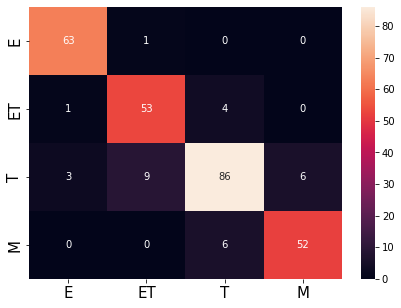

-----------------------------------
Fold 4
-----------------------------------


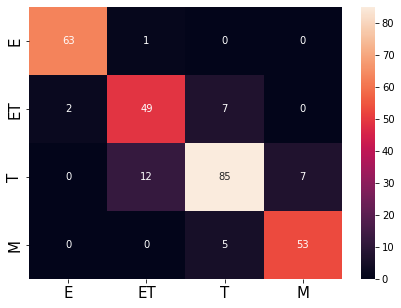

-----------------------------------
Fold 5
-----------------------------------


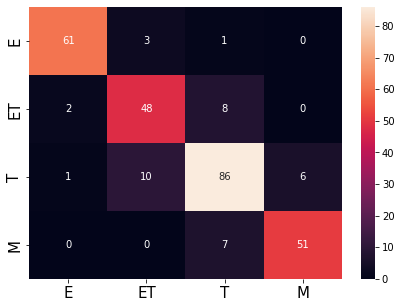

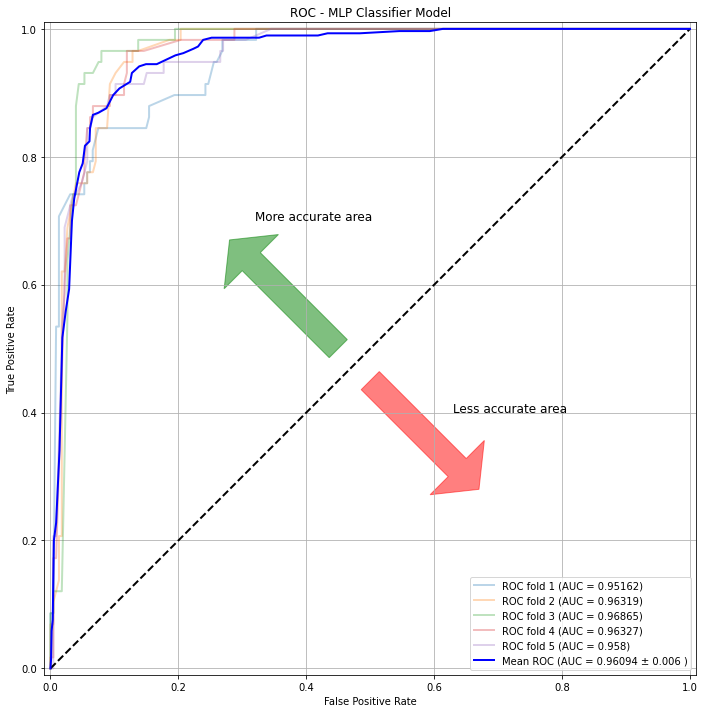

In [24]:
scenery_model = models['MLP_Classifier']['scenery2']

all_ytest = scenery_model['all_ytest']
all_preds = scenery_model['all_preds']
get_confusion_matrix(all_ytest, all_preds)

model = scenery_model['best_estimator']
fprs = scenery_model['roc_fprs']
tprs = scenery_model['roc_tprs']
aucs = scenery_model['roc_aucs']
title = "ROC - MLP Classifier Model" 
get_roc(title, model, fprs, tprs, aucs)

### 4.4.2. All Models <a name = "442"></a>
[Voltar ao Índice](#index)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: SGD_Classifier
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


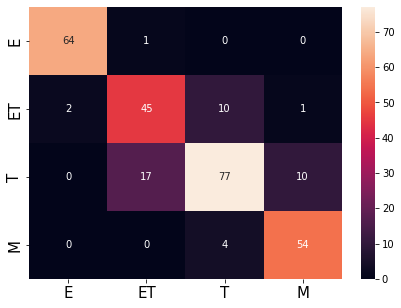

-----------------------------------
Fold 2
-----------------------------------


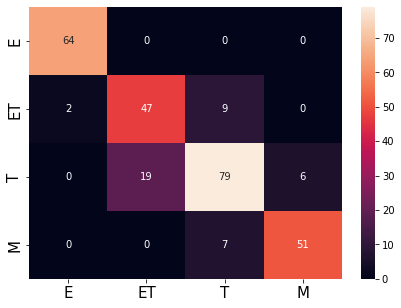

-----------------------------------
Fold 3
-----------------------------------


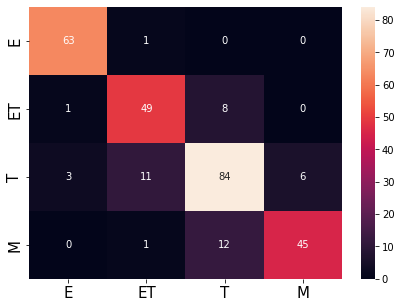

-----------------------------------
Fold 4
-----------------------------------


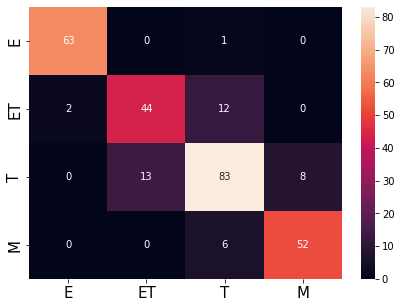

-----------------------------------
Fold 5
-----------------------------------


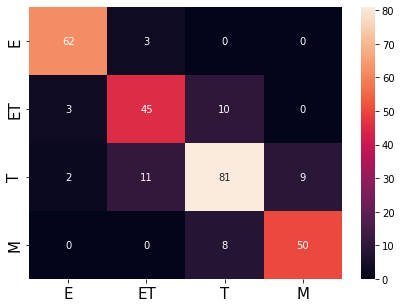

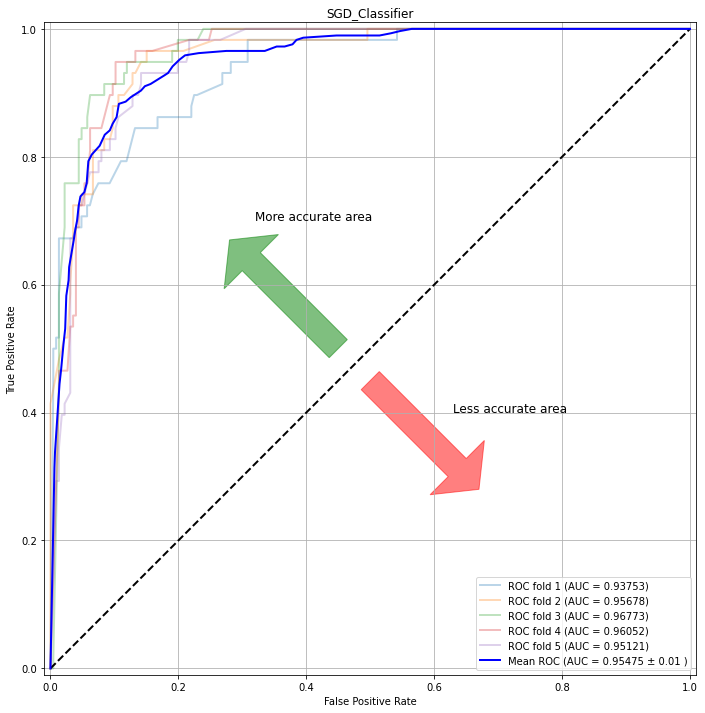

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: Linear_Discriminant_Analysis
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


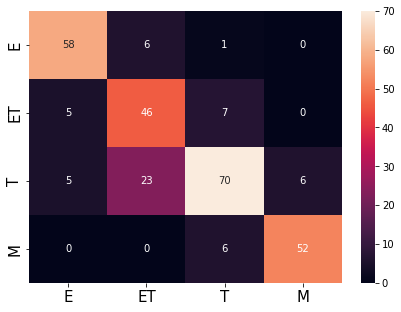

-----------------------------------
Fold 2
-----------------------------------


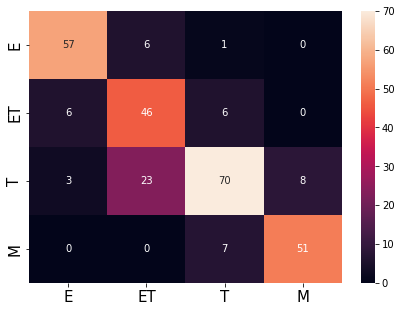

-----------------------------------
Fold 3
-----------------------------------


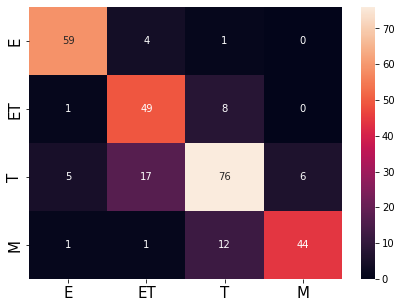

-----------------------------------
Fold 4
-----------------------------------


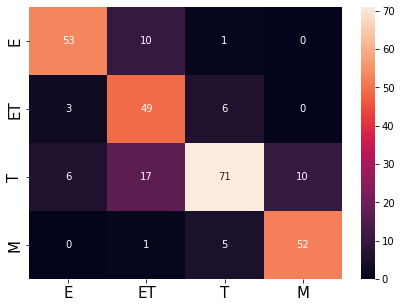

-----------------------------------
Fold 5
-----------------------------------


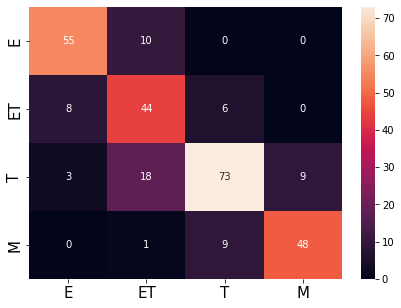

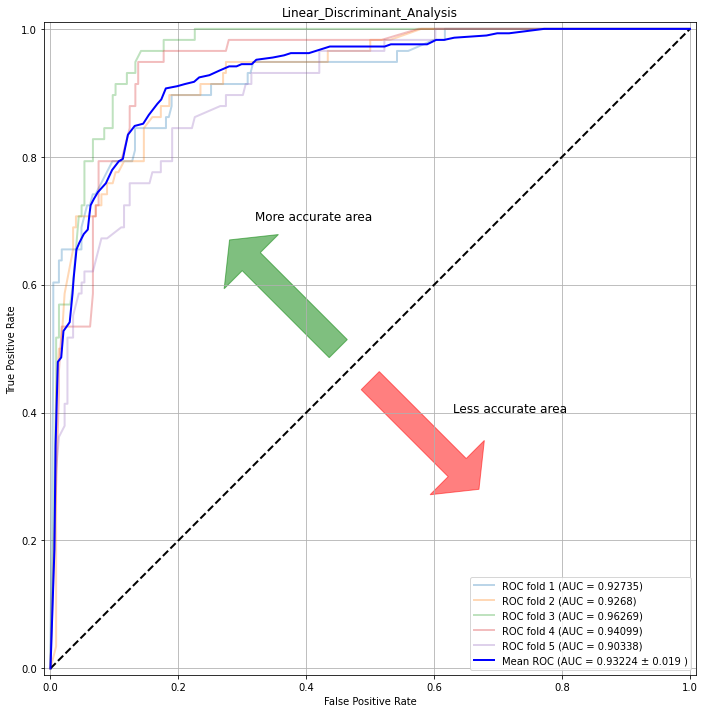

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: K_Neighbors_Classifier
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


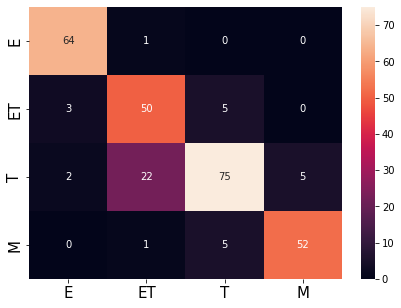

-----------------------------------
Fold 2
-----------------------------------


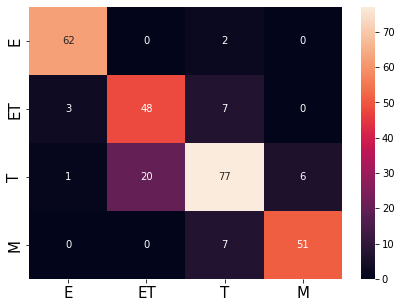

-----------------------------------
Fold 3
-----------------------------------


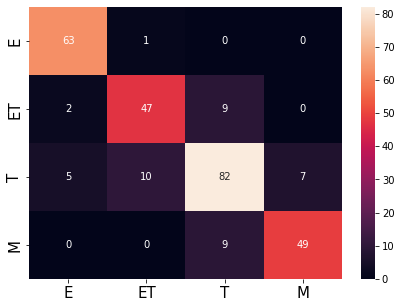

-----------------------------------
Fold 4
-----------------------------------


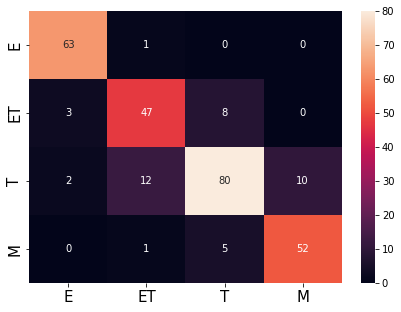

-----------------------------------
Fold 5
-----------------------------------


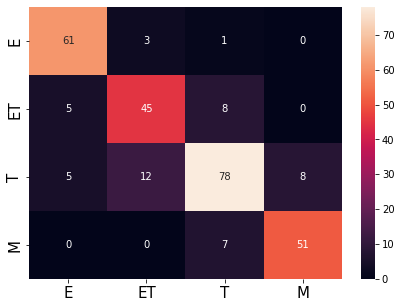

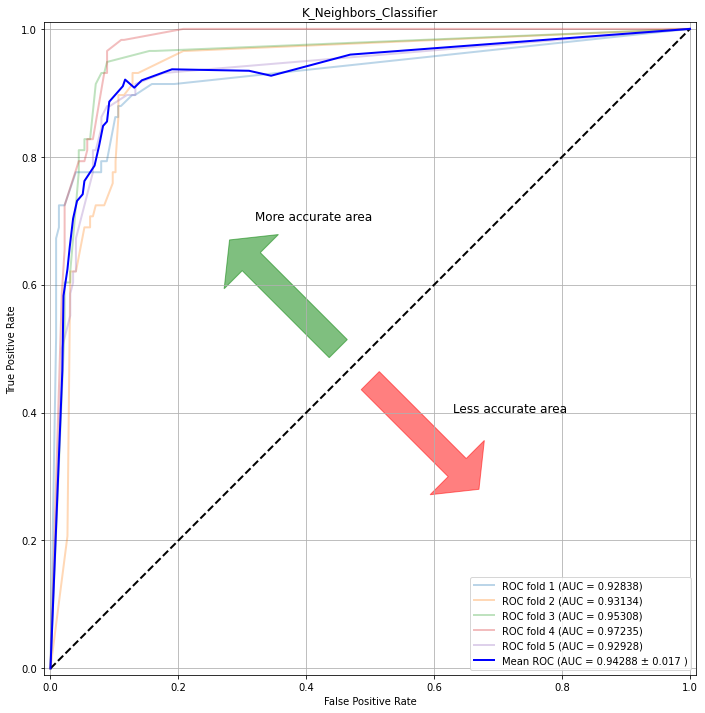

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: Logistic_Regression
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


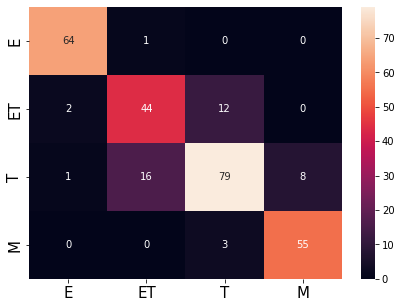

-----------------------------------
Fold 2
-----------------------------------


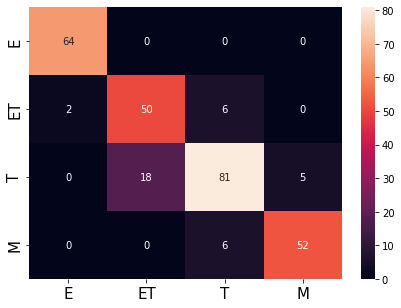

-----------------------------------
Fold 3
-----------------------------------


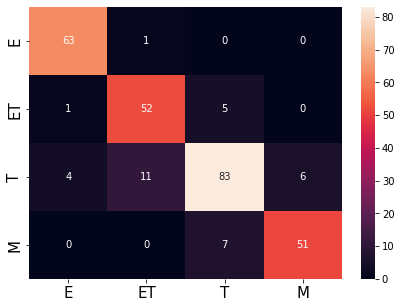

-----------------------------------
Fold 4
-----------------------------------


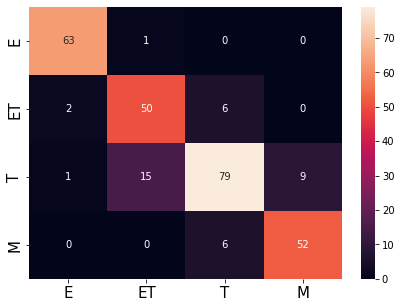

-----------------------------------
Fold 5
-----------------------------------


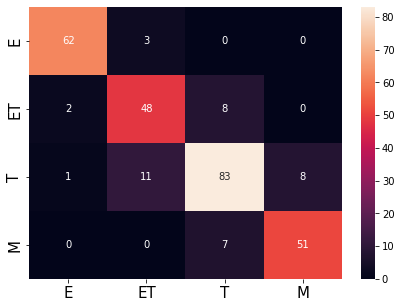

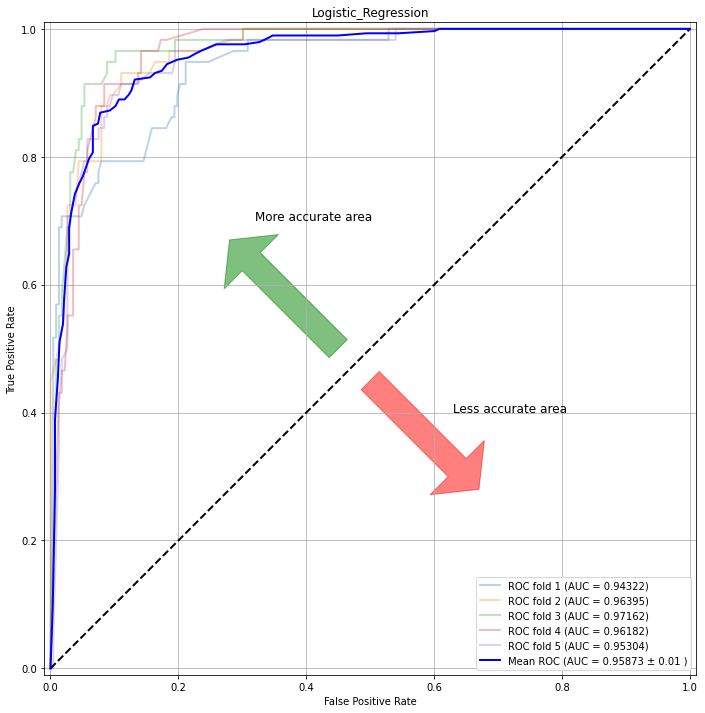

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: Decision_Tree_Classifier
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


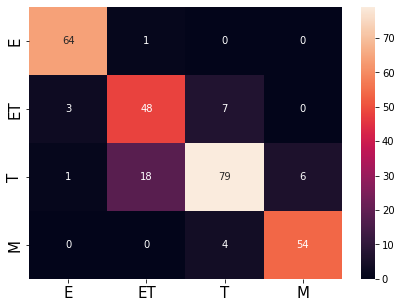

-----------------------------------
Fold 2
-----------------------------------


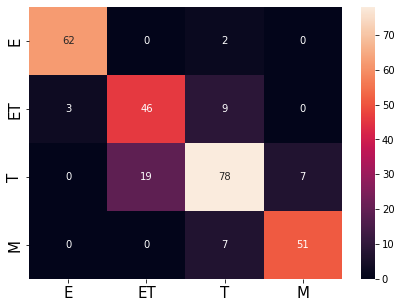

-----------------------------------
Fold 3
-----------------------------------


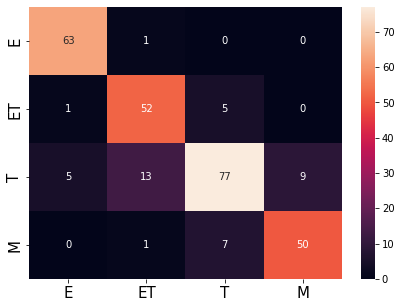

-----------------------------------
Fold 4
-----------------------------------


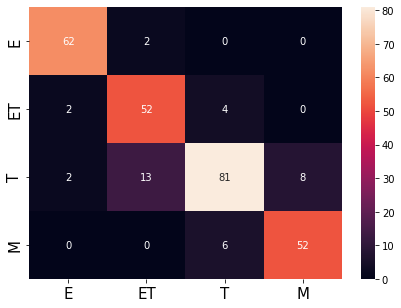

-----------------------------------
Fold 5
-----------------------------------


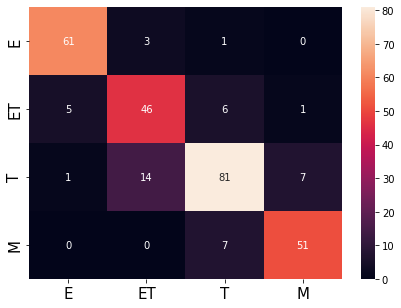

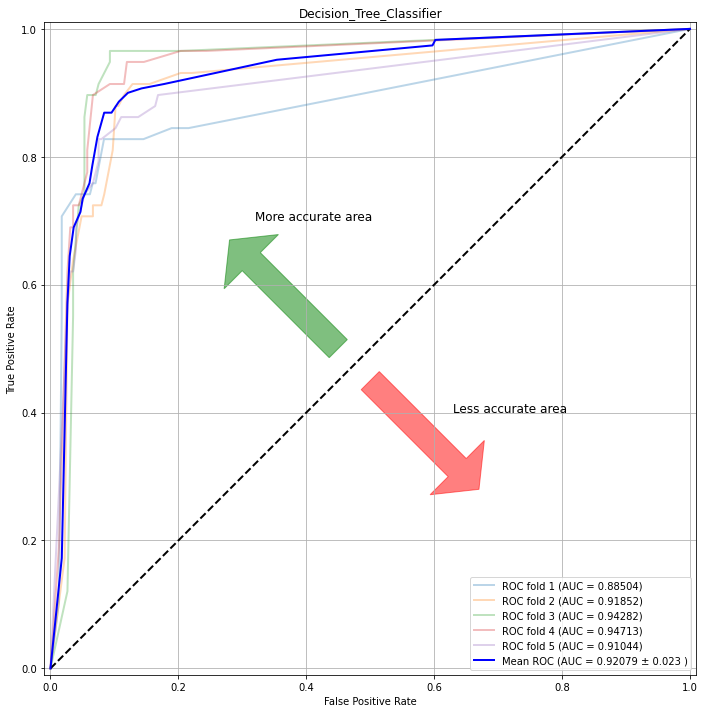

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: SVC
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


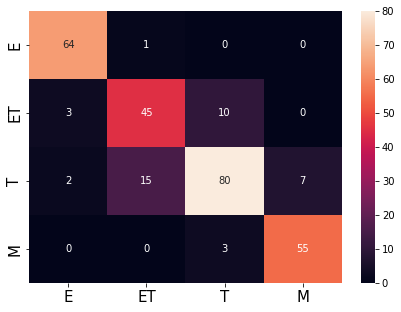

-----------------------------------
Fold 2
-----------------------------------


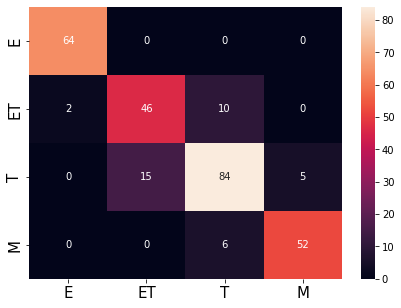

-----------------------------------
Fold 3
-----------------------------------


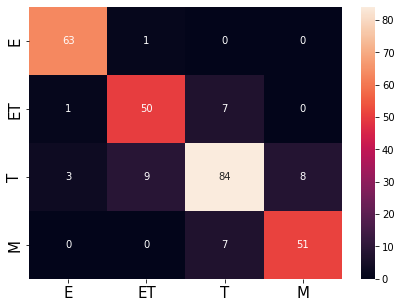

-----------------------------------
Fold 4
-----------------------------------


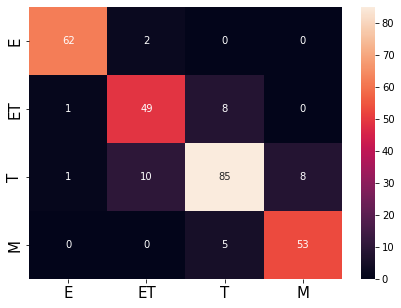

-----------------------------------
Fold 5
-----------------------------------


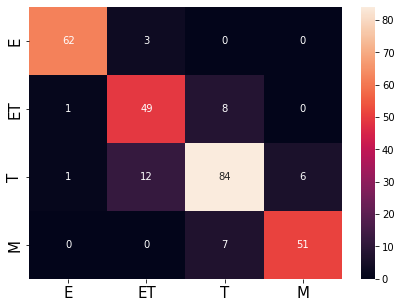

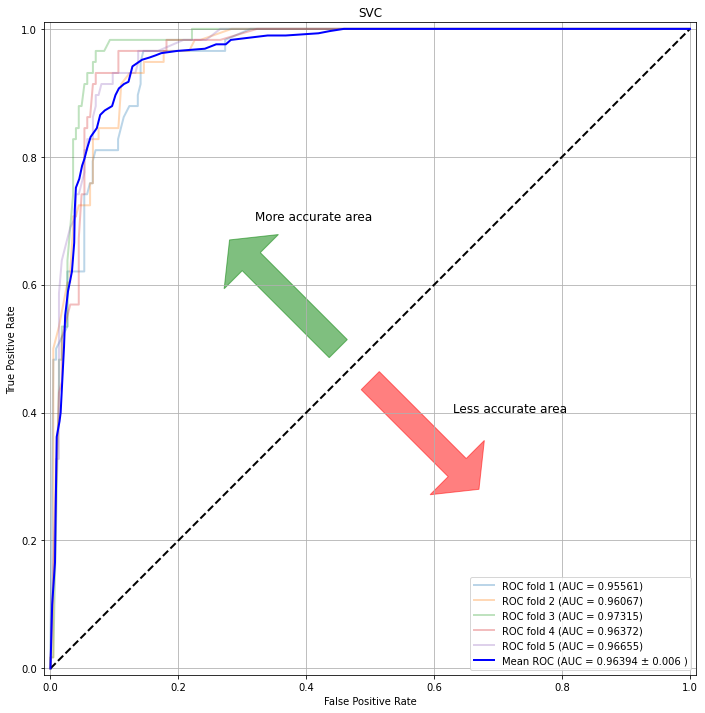

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: Nu_SVC
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


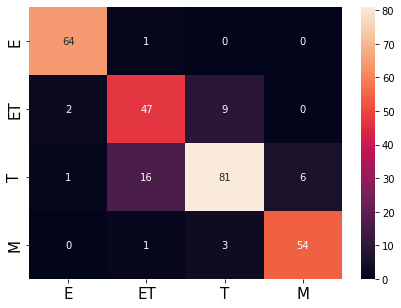

-----------------------------------
Fold 2
-----------------------------------


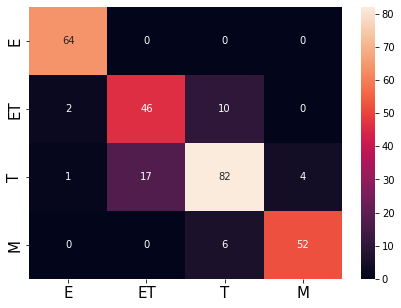

-----------------------------------
Fold 3
-----------------------------------


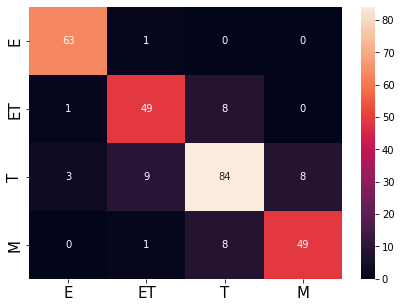

-----------------------------------
Fold 4
-----------------------------------


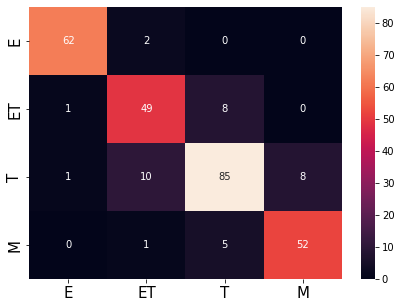

-----------------------------------
Fold 5
-----------------------------------


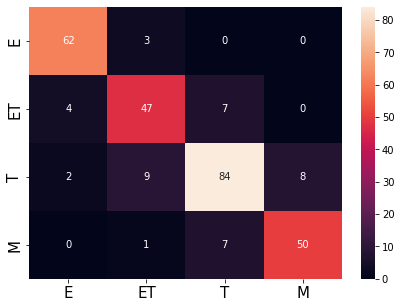

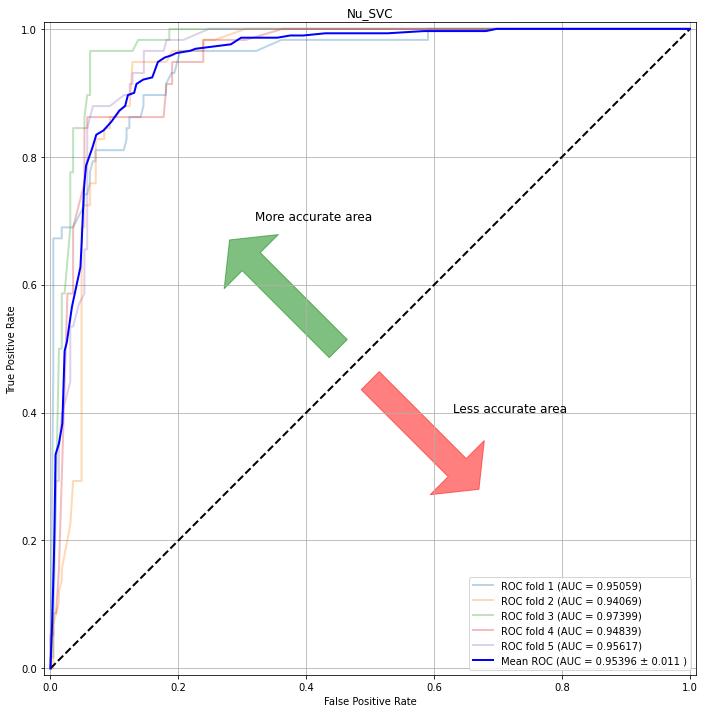

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: MLP_Classifier
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


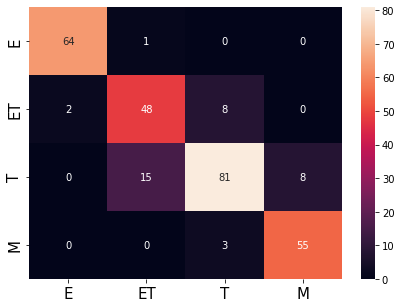

-----------------------------------
Fold 2
-----------------------------------


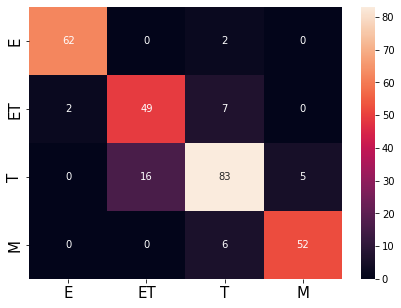

-----------------------------------
Fold 3
-----------------------------------


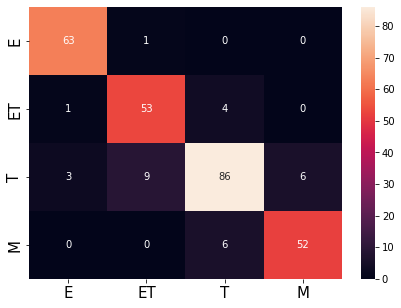

-----------------------------------
Fold 4
-----------------------------------


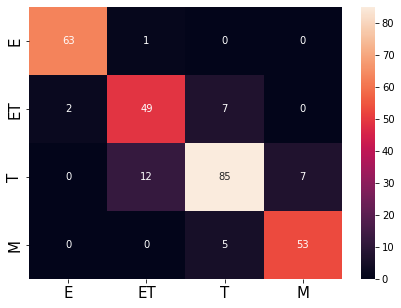

-----------------------------------
Fold 5
-----------------------------------


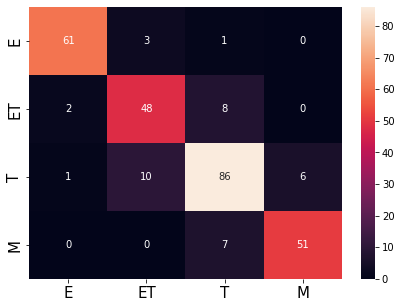

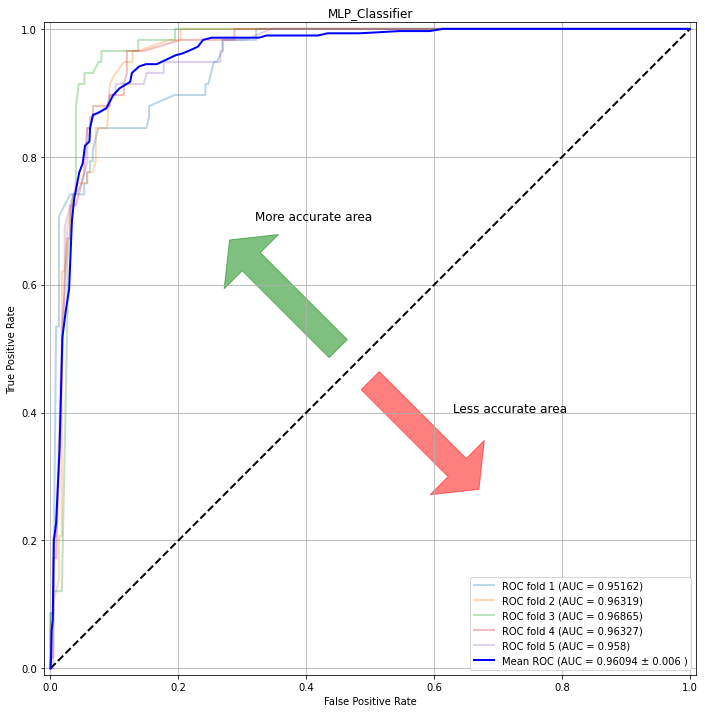

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: Random_Forest_Classifier
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


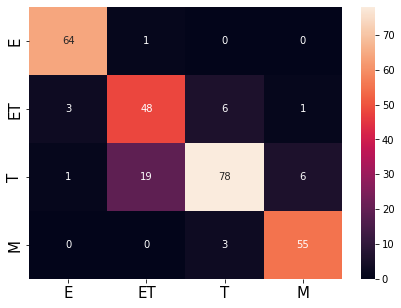

-----------------------------------
Fold 2
-----------------------------------


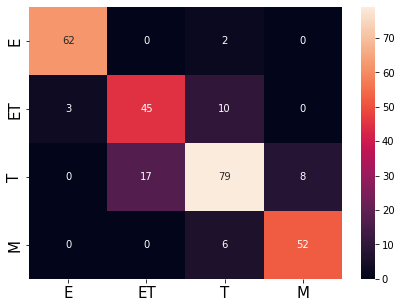

-----------------------------------
Fold 3
-----------------------------------


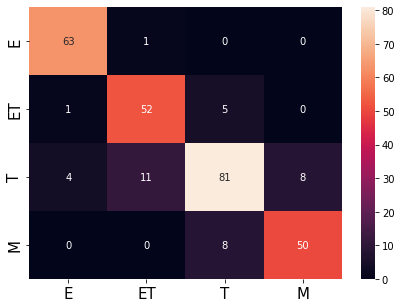

-----------------------------------
Fold 4
-----------------------------------


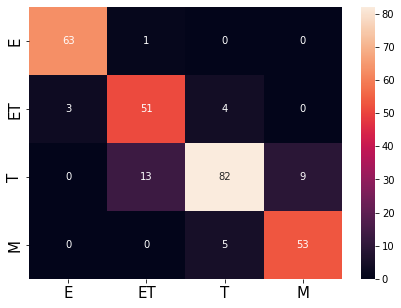

-----------------------------------
Fold 5
-----------------------------------


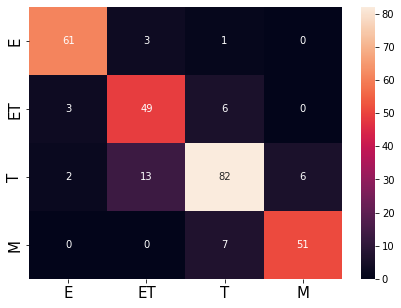

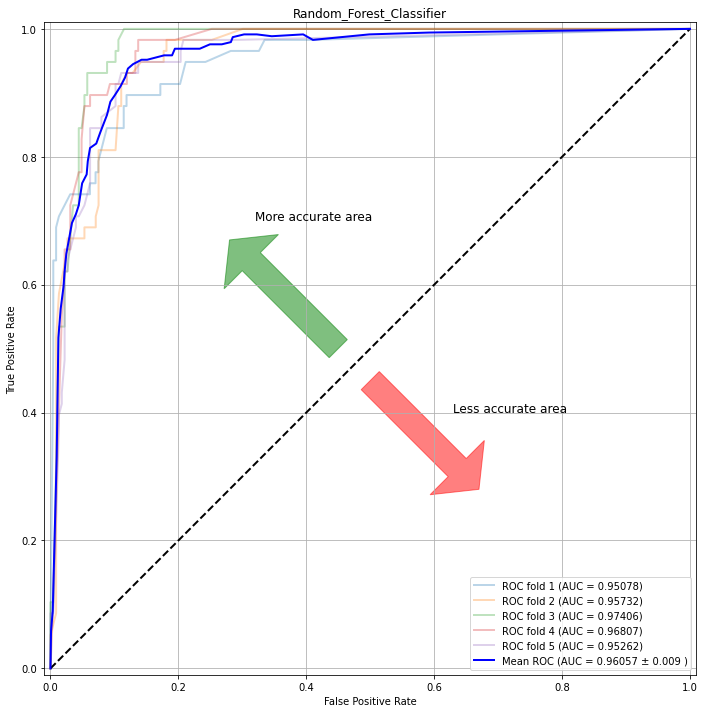

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Model: Gradient_Boosting_Classifier
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-----------------------------------
Fold 1
-----------------------------------


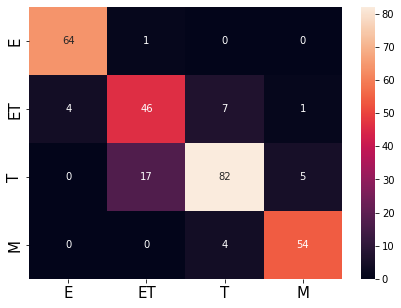

-----------------------------------
Fold 2
-----------------------------------


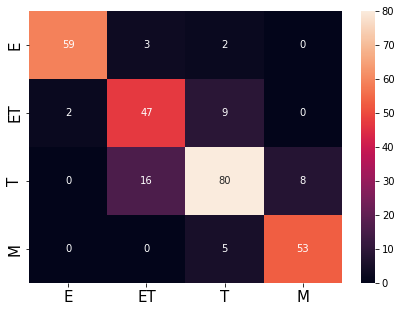

-----------------------------------
Fold 3
-----------------------------------


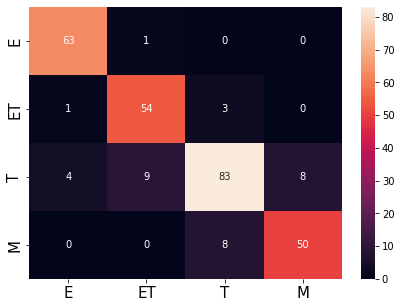

-----------------------------------
Fold 4
-----------------------------------


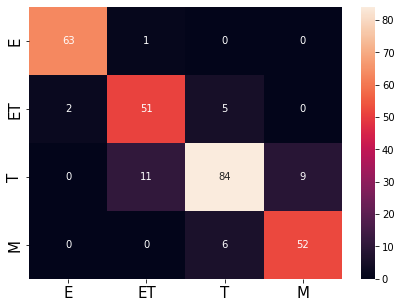

-----------------------------------
Fold 5
-----------------------------------


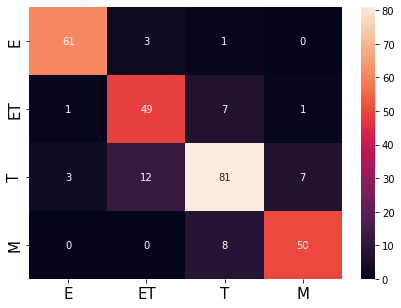

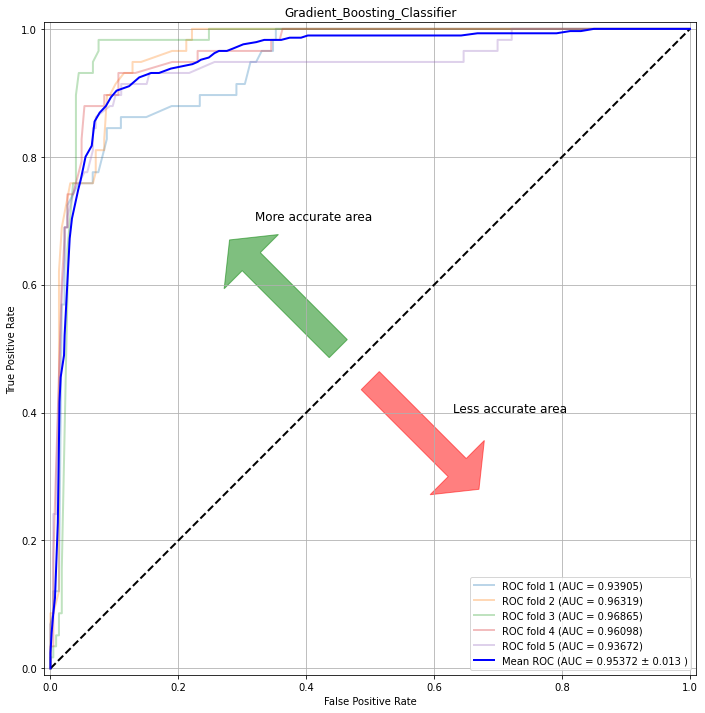

In [25]:
for name, model in models.items():
    print(f'>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>\nModel: {name}\n>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    
    scenery_model = model['scenery2']

    all_ytest = scenery_model['all_ytest']
    all_preds = scenery_model['all_preds']
    get_confusion_matrix(all_ytest, all_preds)

    model = scenery_model['best_estimator']
    fprs = scenery_model['roc_fprs']
    tprs = scenery_model['roc_tprs']
    aucs = scenery_model['roc_aucs']
    title = name
    get_roc(title, model, fprs, tprs, aucs)